### Hourly

 ---

### Import

Reload

In [1]:
%load_ext autoreload
%autoreload 2

##### Installed

In [2]:
# base
import time
import sys, os

In [3]:
# processing
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
# import gym
import ta
# import tsfresh as tsf
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
# connecting
from binance.client import Client
from s3fs.core import S3FileSystem

In [5]:
# d(r)L
import tensorflow as tf

from stable_baselines import PPO2, DQN, A2C
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.callbacks import EvalCallback
from stable_baselines.common import make_vec_env

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [6]:
init_notebook_mode(connected=True)

##### Local

In [7]:
sys.path.append(os.path.dirname(os.getcwd()))

In [8]:
from cryptoast.utils.misc import list_devices
from cryptoast.utils.cred import Cred
from cryptoast.base.kline import Kline, _Kline, Indicators, _Indicators, Signals, _Signals
from cryptoast.base.klines import Klines, KLMngr
from cryptoast.model.agents import Backtest , SingleAssetEnv

##### Functions

In [9]:
def get_weights(size, method='linear', *args):
    if method in ['linear', 'lin']:
        return np.arange(1, size+1)
    elif method in ['exponential', 'exp']:
        a, b = args
        return a**np.linspace(0, b, size)
    return np.ones(size)

### Initialization

In [10]:
cred = Cred()

In [11]:
bases = ['BTC', 'ETH', 'ADA', 'DOT', 'XRP', 'UNI', 'LTC', 'LINK', 'BCH', 'XLM', 'VET', 'IOTA', 'TRX', 'AAVE', 'ATOM', 'EOS', 'AVAX', 'XEM', 'XTZ', 'BTT', 'NEO', 'ALGO', 'CHZ', 'DASH', 'SNX', 'MKR', 'COMP', 'BAT', 'ZEC', 'ETC', 'UMA', 'WAVES', 'YFI', 'ZRX', 'ONT', 'REN', 'DGB', 'OMG', 'QTUM', 'LSK', 'OCEAN', 'KNC', 'REP', 'BAND', 'KMD', 'ANT', 'DOGE', 'ENJ', 'LTO', 'THETA']

In [12]:
quotes_or_assets = []
quotes_or_assets += [_+'USDT' for _ in bases]
# quotes_or_assets += [_+'BTC' for _ in bases if _ != 'BTC']

In [13]:
root_path = 'admin-invest/'
data_path = root_path+'data/'
store_indicators = None #[_ for _ in Kline._store_indicators_default if _[0] not in ('obv')]
store_signals = None
# store_signals = [
#     ('crossovers', ('sma_50', 'sma_200')),
#     ('trend', ('sma_50', 2)),
#     ('pricecross', ('sma_50',)),
#     ('macdcross', (12, 26)),
#     ('rsicross', (14, 30, 70)),
#     ('rsicross2', ())
# ]

In [14]:
# Remote filesystem - No exchange client

iam_key, iam_secret = cred.get('IAM')
s3 = S3FileSystem(anon=False, key=iam_key, secret=iam_secret)
url_scheme = s3.open

client = Client("a","b")

klmngr = KLMngr(quotes_or_assets=quotes_or_assets, client=client, url_scheme=url_scheme, root_path=root_path,
                store_indicators=store_indicators, store_signals=store_signals)

### Update

In [ ]:
print(datetime.utcnow().replace(microsecond=0))

In [ ]:
klmngr.info.reindex(quotes_or_assets).last_update.min()

In [ ]:
klmngr.update(verbose=2)

In [ ]:
klmngr.info.reindex(quotes_or_assets).last_update.min()

### Preprocessing

##### Artificial USDT

### Baseline

Single asset

In [15]:
kline = klmngr['ETHUSDT'] # klmngr[klmngr.assets[1]]
print(kline.asset)

ETHUSDT


In [16]:
index = kline.index[:-1].to_frame().rename(columns={0: 'datetime'})
index = index.assign(index=index.datetime.dt.date)
_sigs = kline.signals.eq(1).mean(axis=1).shift(1).values[:-1]
# _sigs = kline.signals.eq(1).mean(axis=1).rolling(6).mean().shift(1).values[:-1]
# sigs = np.where(_sigs <= -.6, -1, np.where(_sigs >= .8, 1, 0))
sigs = np.where(_sigs < .3, -1, np.where(_sigs >= .8, 1, 0))

In [17]:
btst = Backtest(kline, start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
btst.run(999*sigs, verbose=0)

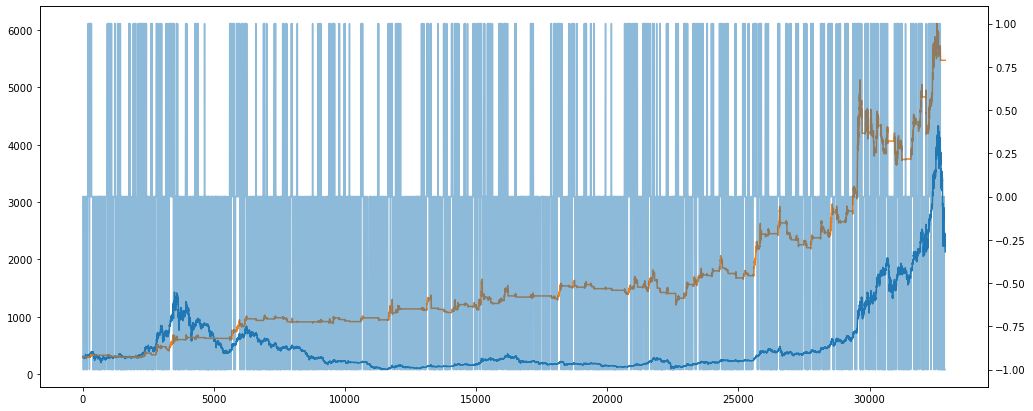

In [18]:
fig, ax = plt.subplots(figsize=(17, 7))
ax.plot(kline.close.values)
ax.plot(btst.periodic.value.values)
ax2 = ax.twinx()
ax2.plot(sigs, alpha=.5)

### Model test 2: RF

##### Manual reloads

In [19]:
from cryptoast.model.agents import SingleAssetEnv

In [20]:
from stable_baselines.common.policies import FeedForwardPolicy, ActorCriticPolicy, register_policy
from stable_baselines.deepq.policies import FeedForwardPolicy as DQNFFP

##### Check for uniform shape within indicators

In [21]:
bad_assets = [asset for asset in klmngr.assets if klmngr[asset].indicators.columns.size != 34]
print(bad_assets)

[]


##### Discrete action, Single Process

Define assets

In [22]:
test_assets = ['ETHUSDT']

In [23]:
train_assets = list(set(klmngr.assets)-set(test_assets)-set(bad_assets))

Testing ground

In [205]:
asset = np.random.choice(klmngr.assets) # 'BTCUSDT'
btst = Backtest(kline=klmngr[asset], memory=6)
env = SingleAssetEnv(klmngr, assets=train_assets, backtest=btst, window=1, )

In [385]:
pd.Series(0, index=pd.date_range("20200101", "20200201", freq="D")).resample(rule='H').agg

<bound method Resampler.aggregate of <pandas.core.resample.DatetimeIndexResampler object at 0x000001DFB7E799C8>>

In [372]:
kline.daily.indicators.isnull().all()

sma_50             False
sma_200            False
ema_12             False
ema_26             False
wma_9              False
macd_12_26         False
macd_sign_12_26    False
macd_diff_12_26    False
adx                False
adx_pos            False
adx_neg            False
rsi                False
atr                False
bb_hband           False
bb_mband           False
bb_lband           False
cmf                False
dc_hband           False
dc_mband           False
dc_lband           False
kc_hband           False
kc_mband           False
kc_lband           False
mfi_14             False
obv                False
psar               False
psarup             False
psardown           False
roc                False
stoch_k            False
stoch_k_signal     False
vwap_14            False
d_ret              False
d_logret           False
dtype: bool

In [359]:
env.reset()
print(env.kline.asset)
steps = []
for i in range(10000):
    action = np.random.choice([0, 1, 2])
    try:
        steps.append(env.step(action))
    except IndexError as e:
        break
print(i)
obss_raw = np.vstack([step[0] for step in steps])
vals_raw = np.array([list(step[-1]['periodic'].values())[0]['value'] for step in steps])

BATUSDT
9999


In [211]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor

In [363]:
obss, vals = obss_raw, vals_raw
vals = pd.Series(vals).pct_change().shift(-1).values
# vals = pd.Series(vals).shift(-1).fillna(0).values
# scaler = StandardScaler()
# vals = scaler.fit_transform(vals.reshape(-1, 1)).flatten()
mod = RandomForestRegressor()
mod.fit(X=obss[:-i//4], y=vals[:-i//4])
preds = mod.predict(obss)

In [364]:
accuracy_score(vals[-i//4:]>0, preds[-i//4:]>0), roc_auc_score(vals[-i//4:]>0, preds[-i//4:]>0)

(0.5536, 0.518892111775408)

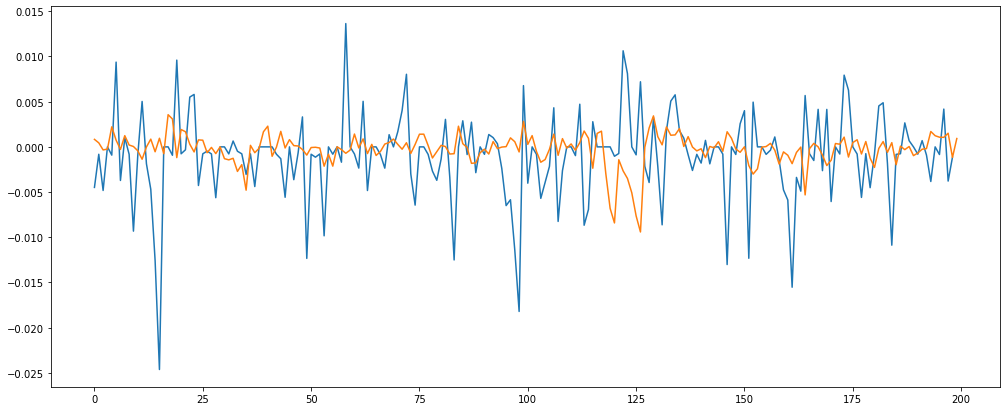

In [365]:
fig, ax = plt.subplots(figsize=(17, 7))
# plt.plot((vals-preds)[-i//4:])
# plt.plot(vals[-i//4:])
# plt.plot(preds[-i//4:])
plt.plot(vals[-200:])
plt.plot(preds[-200:])
# plt.ylim([-0.025, 0.025])

100


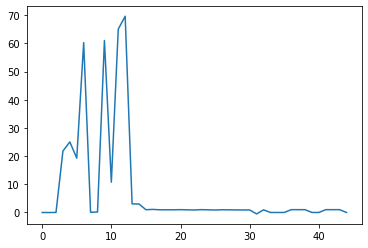

In [25]:
# obs = env.step(np.random.choice([0, 1, 2]))[0]
obs = [env.step(_) for _ in np.random.choice([0, 1, 2], size=100)][-1][0]
print(env.current_step)
plt.plot(obs)

In [206]:
check_env(env)

In [151]:
obs = env.reset()

0.0001106244743498408


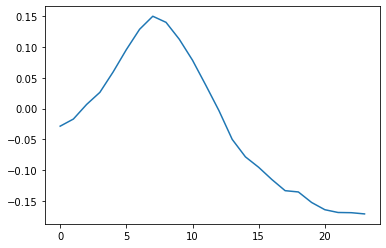

In [55]:
obs, reward, _, __ = env.step(2)
plt.plot(obs[:24])
print(reward)

DQN

In [ ]:
# Custom MLP policy of three layers of size 128 each
class CustomDQNPolicy(DQNFFP):
    def __init__(self, *args, **kwargs):
        super(CustomDQNPolicy, self).__init__(*args, **kwargs,
                                           layers=[64, 64, 64, 64],
                                           layer_norm=True,
                                           feature_extraction="mlp")

In [207]:
window = 1
btst = Backtest(init_assets=0, init_cash=1000, commission=0.001, slippage_pct=0, slippage_steps=0, memory=6)
env_kwargs = dict(klmngr=klmngr,
                  assets=train_assets,
                  backtest=btst,
                  window=window,
                  datetimes=pd.Timestamp(2020, 1, 1),
                  randomize_start=True,
                  allow_gaps=False,
                  episode_steps=24*30*2)
env = SingleAssetEnv(**env_kwargs)
env = make_vec_env(lambda: env, n_envs=1)

In [208]:
eval_callback = EvalCallback(env, 
                             best_model_save_path='../models/h5/',
                             log_path='../models/logs/',
                             eval_freq=500,
                             deterministic=True, 
                             render=False)

In [209]:
total_timesteps = 500*1000
tensorboard_log = '../models/logs_tensorboard/' # None
# model = DQN(policy='MlpPolicy', env=env, exploration_fraction=.2, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=1, prioritized_replay=True, verbose=1, tensorboard_log=tensorboard_log)
# model = DQN(policy=CustomDQNPolicy, env=env, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=1, prioritized_replay=True, verbose=1)

# model = DQN(policy=CustomDQNPolicy, env=env, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=1, prioritized_replay=True, tensorboard_log='C:/Users/guill/Documents/Code/crypto-invest/models/logs', verbose=1)
model = PPO2(policy='MlpPolicy', env=env, verbose=1, tensorboard_log=tensorboard_log)
# model = A2C(policy='MlpPolicy', env=env, verbose=1)

In [210]:
# model.learn(total_timesteps)
model.learn(total_timesteps, callback=eval_callback)

--------------------------------------
| approxkl           | 0.00022424082 |
| clipfrac           | 0.0           |
| explained_variance | 0.00617       |
| fps                | 109           |
| n_updates          | 1             |
| policy_entropy     | 1.0983729     |
| policy_loss        | -0.002294369  |
| serial_timesteps   | 128           |
| time_elapsed       | 0             |
| total_timesteps    | 128           |
| value_loss         | 677.0448      |
--------------------------------------
---------------------------------------
| approxkl           | 8.2847735e-05  |
| clipfrac           | 0.0            |
| explained_variance | 0.0197         |
| fps                | 135            |
| n_updates          | 2              |
| policy_entropy     | 1.0972742      |
| policy_loss        | -0.00029169384 |
| serial_timesteps   | 256            |
| time_elapsed       | 1.16           |
| total_timesteps    | 256            |
| value_loss         | 209.2809       |
-------------

---------------------------------------
| approxkl           | 4.380732e-06   |
| clipfrac           | 0.0            |
| ep_len_mean        | 124            |
| ep_reward_mean     | -57.4          |
| explained_variance | -0.0192        |
| fps                | 119            |
| n_updates          | 15             |
| policy_entropy     | 1.0904124      |
| policy_loss        | -0.00020456256 |
| serial_timesteps   | 1920           |
| time_elapsed       | 58.1           |
| total_timesteps    | 1920           |
| value_loss         | 139.6107       |
---------------------------------------
Eval num_timesteps=2000, episode_reward=-44.61 +/- 20.85
Episode length: 616.40 +/- 349.96
--------------------------------------
| approxkl           | 6.9427447e-06 |
| clipfrac           | 0.0           |
| ep_len_mean        | 124           |
| ep_reward_mean     | -57.4         |
| explained_variance | 0.0252        |
| fps                | 6             |
| n_updates          | 16           

---------------------------------------
| approxkl           | 2.1370154e-06  |
| clipfrac           | 0.0            |
| ep_len_mean        | 159            |
| ep_reward_mean     | -49.4          |
| explained_variance | -0.00527       |
| fps                | 332            |
| n_updates          | 29             |
| policy_entropy     | 1.0906017      |
| policy_loss        | -0.00017429155 |
| serial_timesteps   | 3712           |
| time_elapsed       | 150            |
| total_timesteps    | 3712           |
| value_loss         | 286.90976      |
---------------------------------------
--------------------------------------
| approxkl           | 0.00010743672 |
| clipfrac           | 0.0           |
| ep_len_mean        | 159           |
| ep_reward_mean     | -49.4         |
| explained_variance | 0.0693        |
| fps                | 323           |
| n_updates          | 30            |
| policy_entropy     | 1.0891533     |
| policy_loss        | -0.0031224452 |
| serial_t

Eval num_timesteps=5500, episode_reward=-306.17 +/- 701.66
Episode length: 1391.80 +/- 96.40
---------------------------------------
| approxkl           | 5.651027e-06   |
| clipfrac           | 0.0            |
| ep_len_mean        | 157            |
| ep_reward_mean     | -8.21          |
| explained_variance | 0.00977        |
| fps                | 3              |
| n_updates          | 43             |
| policy_entropy     | 1.0949452      |
| policy_loss        | -0.00011126464 |
| serial_timesteps   | 5504           |
| time_elapsed       | 234            |
| total_timesteps    | 5504           |
| value_loss         | 295.70068      |
---------------------------------------
--------------------------------------
| approxkl           | 2.617637e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 157           |
| ep_reward_mean     | -8.21         |
| explained_variance | 0.0245        |
| fps                | 106           |
| n_updates          | 44         

--------------------------------------
| approxkl           | 0.00045098562 |
| clipfrac           | 0.0           |
| ep_len_mean        | 152           |
| ep_reward_mean     | -4.65         |
| explained_variance | 0.0345        |
| fps                | 180           |
| n_updates          | 57            |
| policy_entropy     | 1.0916336     |
| policy_loss        | -0.0033753081 |
| serial_timesteps   | 7296          |
| time_elapsed       | 337           |
| total_timesteps    | 7296          |
| value_loss         | 55.464413     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00039888342 |
| clipfrac           | 0.0           |
| ep_len_mean        | 152           |
| ep_reward_mean     | -4.65         |
| explained_variance | 0.00508       |
| fps                | 183           |
| n_updates          | 58            |
| policy_entropy     | 1.092485      |
| policy_loss        | 0.00039128133 |
| serial_timesteps   | 74

Eval num_timesteps=9000, episode_reward=-65.21 +/- 162.53
Episode length: 776.00 +/- 554.11
--------------------------------------
| approxkl           | 1.3793491e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 152           |
| ep_reward_mean     | -4.65         |
| explained_variance | 0.281         |
| fps                | 5             |
| n_updates          | 71            |
| policy_entropy     | 1.0769312     |
| policy_loss        | -0.0005982891 |
| serial_timesteps   | 9088          |
| time_elapsed       | 430           |
| total_timesteps    | 9088          |
| value_loss         | 45.24137      |
--------------------------------------
--------------------------------------
| approxkl           | 4.1755455e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 152           |
| ep_reward_mean     | -4.65         |
| explained_variance | -0.00499      |
| fps                | 324           |
| n_updates          | 72            |
| policy_en

---------------------------------------
| approxkl           | 1.6628199e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 142            |
| ep_reward_mean     | -0.145         |
| explained_variance | 0.108          |
| fps                | 158            |
| n_updates          | 85             |
| policy_entropy     | 1.079935       |
| policy_loss        | -0.00060820347 |
| serial_timesteps   | 10880          |
| time_elapsed       | 546            |
| total_timesteps    | 10880          |
| value_loss         | 223.75111      |
---------------------------------------
Eval num_timesteps=11000, episode_reward=113.79 +/- 109.08
Episode length: 512.20 +/- 335.55
New best mean reward!
--------------------------------------
| approxkl           | 8.971832e-06  |
| clipfrac           | 0.0           |
| ep_len_mean        | 142           |
| ep_reward_mean     | -0.145        |
| explained_variance | 0.0177        |
| fps                | 10            |
| n_updates 

--------------------------------------
| approxkl           | 0.00021387718 |
| clipfrac           | 0.0           |
| ep_len_mean        | 143           |
| ep_reward_mean     | 0.162         |
| explained_variance | -0.0661       |
| fps                | 248           |
| n_updates          | 99            |
| policy_entropy     | 1.0418509     |
| policy_loss        | -0.0036586216 |
| serial_timesteps   | 12672         |
| time_elapsed       | 624           |
| total_timesteps    | 12672         |
| value_loss         | 18.610828     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00014207863 |
| clipfrac           | 0.0           |
| ep_len_mean        | 143           |
| ep_reward_mean     | 0.162         |
| explained_variance | -0.0415       |
| fps                | 360           |
| n_updates          | 100           |
| policy_entropy     | 1.0333004     |
| policy_loss        | 0.0012154081  |
| serial_timesteps   | 12

--------------------------------------
| approxkl           | 8.664609e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 155           |
| ep_reward_mean     | -0.565        |
| explained_variance | -0.0846       |
| fps                | 115           |
| n_updates          | 113           |
| policy_entropy     | 1.0630252     |
| policy_loss        | -0.0033229257 |
| serial_timesteps   | 14464         |
| time_elapsed       | 717           |
| total_timesteps    | 14464         |
| value_loss         | 86.15454      |
--------------------------------------
Eval num_timesteps=14500, episode_reward=-131.62 +/- 671.18
Episode length: 818.40 +/- 201.24
--------------------------------------
| approxkl           | 2.1543598e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 155           |
| ep_reward_mean     | -0.565        |
| explained_variance | -0.0205       |
| fps                | 5             |
| n_updates          | 114           |
| policy_

--------------------------------------
| approxkl           | 3.9711213e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 155           |
| ep_reward_mean     | -0.565        |
| explained_variance | -0.011        |
| fps                | 178           |
| n_updates          | 127           |
| policy_entropy     | 0.9835626     |
| policy_loss        | -0.000614717  |
| serial_timesteps   | 16256         |
| time_elapsed       | 791           |
| total_timesteps    | 16256         |
| value_loss         | 94.04842      |
--------------------------------------
---------------------------------------
| approxkl           | 2.143663e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 155            |
| ep_reward_mean     | -0.565         |
| explained_variance | -0.0393        |
| fps                | 191            |
| n_updates          | 128            |
| policy_entropy     | 0.9849035      |
| policy_loss        | -0.00088428217 |
| serial_timest

Eval num_timesteps=18000, episode_reward=90.97 +/- 69.29
Episode length: 631.00 +/- 504.33
---------------------------------------
| approxkl           | 6.513928e-06   |
| clipfrac           | 0.0            |
| ep_len_mean        | 155            |
| ep_reward_mean     | 4.09           |
| explained_variance | 0.0562         |
| fps                | 5              |
| n_updates          | 141            |
| policy_entropy     | 0.98652166     |
| policy_loss        | -0.00039161043 |
| serial_timesteps   | 18048          |
| time_elapsed       | 878            |
| total_timesteps    | 18048          |
| value_loss         | 471.695        |
---------------------------------------
--------------------------------------
| approxkl           | 3.2435888e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 155           |
| ep_reward_mean     | 4.09          |
| explained_variance | 0.0137        |
| fps                | 307           |
| n_updates          | 142          

-------------------------------------
| approxkl           | 0.0023695221 |
| clipfrac           | 0.009765625  |
| ep_len_mean        | 155          |
| ep_reward_mean     | 4.09         |
| explained_variance | 0.0111       |
| fps                | 261          |
| n_updates          | 155          |
| policy_entropy     | 1.0821255    |
| policy_loss        | -0.013024223 |
| serial_timesteps   | 19840        |
| time_elapsed       | 976          |
| total_timesteps    | 19840        |
| value_loss         | 365.02057    |
-------------------------------------
--------------------------------------
| approxkl           | 0.00021970116 |
| clipfrac           | 0.0           |
| ep_len_mean        | 155           |
| ep_reward_mean     | 4.09          |
| explained_variance | 0.0589        |
| fps                | 203           |
| n_updates          | 156           |
| policy_entropy     | 1.075671      |
| policy_loss        | -0.0003546977 |
| serial_timesteps   | 19968         |
|

--------------------------------------
| approxkl           | 2.2812525e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 160           |
| ep_reward_mean     | -1.05         |
| explained_variance | 0.0672        |
| fps                | 200           |
| n_updates          | 169           |
| policy_entropy     | 0.9671608     |
| policy_loss        | 0.00022877869 |
| serial_timesteps   | 21632         |
| time_elapsed       | 1.06e+03      |
| total_timesteps    | 21632         |
| value_loss         | 446.72076     |
--------------------------------------
---------------------------------------
| approxkl           | 6.6277835e-06  |
| clipfrac           | 0.0            |
| ep_len_mean        | 160            |
| ep_reward_mean     | -1.05          |
| explained_variance | -0.00836       |
| fps                | 177            |
| n_updates          | 170            |
| policy_entropy     | 0.96701944     |
| policy_loss        | -0.00049082644 |
| serial_timest

---------------------------------------
| approxkl           | 1.9575726e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 170            |
| ep_reward_mean     | -0.465         |
| explained_variance | 0.0764         |
| fps                | 164            |
| n_updates          | 183            |
| policy_entropy     | 0.93707466     |
| policy_loss        | -0.00051878265 |
| serial_timesteps   | 23424          |
| time_elapsed       | 1.15e+03       |
| total_timesteps    | 23424          |
| value_loss         | 429.48233      |
---------------------------------------
Eval num_timesteps=23500, episode_reward=17.38 +/- 33.58
Episode length: 601.00 +/- 685.25
--------------------------------------
| approxkl           | 0.00012050249 |
| clipfrac           | 0.0           |
| ep_len_mean        | 170           |
| ep_reward_mean     | -0.465        |
| explained_variance | -0.0914       |
| fps                | 5             |
| n_updates          | 184          

--------------------------------------
| approxkl           | 4.723389e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 157           |
| ep_reward_mean     | -2.32         |
| explained_variance | 0.243         |
| fps                | 84            |
| n_updates          | 197           |
| policy_entropy     | 0.9140967     |
| policy_loss        | -0.0012514673 |
| serial_timesteps   | 25216         |
| time_elapsed       | 1.23e+03      |
| total_timesteps    | 25216         |
| value_loss         | 119.83616     |
--------------------------------------
---------------------------------------
| approxkl           | 7.430935e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 157            |
| ep_reward_mean     | -2.32          |
| explained_variance | 0.0114         |
| fps                | 102            |
| n_updates          | 198            |
| policy_entropy     | 0.91115713     |
| policy_loss        | -0.00011047791 |
| serial_timest

Eval num_timesteps=27000, episode_reward=-15.74 +/- 251.24
Episode length: 895.60 +/- 479.17
--------------------------------------
| approxkl           | 0.0013920926  |
| clipfrac           | 0.0           |
| ep_len_mean        | 163           |
| ep_reward_mean     | -8.62         |
| explained_variance | -0.0808       |
| fps                | 6             |
| n_updates          | 211           |
| policy_entropy     | 0.9042419     |
| policy_loss        | -0.0018311352 |
| serial_timesteps   | 27008         |
| time_elapsed       | 1.31e+03      |
| total_timesteps    | 27008         |
| value_loss         | 153.01656     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0006036112 |
| clipfrac           | 0.0          |
| ep_len_mean        | 163          |
| ep_reward_mean     | -8.62        |
| explained_variance | -0.018       |
| fps                | 95           |
| n_updates          | 212          |
| policy_entropy  

--------------------------------------
| approxkl           | 0.00023400126 |
| clipfrac           | 0.0           |
| ep_len_mean        | 166           |
| ep_reward_mean     | -4.68         |
| explained_variance | 0.0218        |
| fps                | 146           |
| n_updates          | 225           |
| policy_entropy     | 0.84705234    |
| policy_loss        | -0.0023399151 |
| serial_timesteps   | 28800         |
| time_elapsed       | 1.4e+03       |
| total_timesteps    | 28800         |
| value_loss         | 473.08368     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0004687613  |
| clipfrac           | 0.0           |
| ep_len_mean        | 166           |
| ep_reward_mean     | -4.68         |
| explained_variance | 0.0297        |
| fps                | 180           |
| n_updates          | 226           |
| policy_entropy     | 0.8383596     |
| policy_loss        | -0.0013764027 |
| serial_timesteps   | 28

Eval num_timesteps=30500, episode_reward=-59.42 +/- 295.99
Episode length: 856.20 +/- 525.04
--------------------------------------
| approxkl           | 0.00016372102 |
| clipfrac           | 0.0           |
| ep_len_mean        | 166           |
| ep_reward_mean     | -4.68         |
| explained_variance | 0.206         |
| fps                | 6             |
| n_updates          | 239           |
| policy_entropy     | 0.8888091     |
| policy_loss        | -0.0024755797 |
| serial_timesteps   | 30592         |
| time_elapsed       | 1.47e+03      |
| total_timesteps    | 30592         |
| value_loss         | 161.80626     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00025413345 |
| clipfrac           | 0.0           |
| ep_len_mean        | 166           |
| ep_reward_mean     | -1.74         |
| explained_variance | 0.163         |
| fps                | 213           |
| n_updates          | 240           |
| policy_e

---------------------------------------
| approxkl           | 0.000117780015 |
| clipfrac           | 0.0            |
| ep_len_mean        | 164            |
| ep_reward_mean     | -3.59          |
| explained_variance | 0.219          |
| fps                | 119            |
| n_updates          | 253            |
| policy_entropy     | 0.8401069      |
| policy_loss        | -0.0005393805  |
| serial_timesteps   | 32384          |
| time_elapsed       | 1.58e+03       |
| total_timesteps    | 32384          |
| value_loss         | 33.349648      |
---------------------------------------
Eval num_timesteps=32500, episode_reward=-16.19 +/- 153.98
Episode length: 399.20 +/- 515.83
--------------------------------------
| approxkl           | 0.00023396402 |
| clipfrac           | 0.0           |
| ep_len_mean        | 170           |
| ep_reward_mean     | -8.29         |
| explained_variance | 0.266         |
| fps                | 8             |
| n_updates          | 254        

-------------------------------------
| approxkl           | 0.0004692621 |
| clipfrac           | 0.0          |
| ep_len_mean        | 170          |
| ep_reward_mean     | -8.15        |
| explained_variance | -0.0148      |
| fps                | 209          |
| n_updates          | 267          |
| policy_entropy     | 0.8702973    |
| policy_loss        | -0.001655272 |
| serial_timesteps   | 34176        |
| time_elapsed       | 1.67e+03     |
| total_timesteps    | 34176        |
| value_loss         | 1993.8011    |
-------------------------------------
--------------------------------------
| approxkl           | 0.006413522   |
| clipfrac           | 0.08203125    |
| ep_len_mean        | 170           |
| ep_reward_mean     | -8.15         |
| explained_variance | 0.0296        |
| fps                | 191           |
| n_updates          | 268           |
| policy_entropy     | 0.9026268     |
| policy_loss        | -0.0031553989 |
| serial_timesteps   | 34304         |
|

--------------------------------------
| approxkl           | 4.9014416e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 175           |
| ep_reward_mean     | -11.5         |
| explained_variance | 0.0407        |
| fps                | 210           |
| n_updates          | 281           |
| policy_entropy     | 0.9229545     |
| policy_loss        | -0.0014982736 |
| serial_timesteps   | 35968         |
| time_elapsed       | 1.75e+03      |
| total_timesteps    | 35968         |
| value_loss         | 253.0358      |
--------------------------------------
Eval num_timesteps=36000, episode_reward=-275.51 +/- 545.71
Episode length: 1069.40 +/- 304.34
---------------------------------------
| approxkl           | 3.4496872e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 172            |
| ep_reward_mean     | -8.61          |
| explained_variance | -0.128         |
| fps                | 5              |
| n_updates          | 282            |


--------------------------------------
| approxkl           | 0.00012674846 |
| clipfrac           | 0.0           |
| ep_len_mean        | 172           |
| ep_reward_mean     | -8.61         |
| explained_variance | 0.0217        |
| fps                | 209           |
| n_updates          | 295           |
| policy_entropy     | 1.0788921     |
| policy_loss        | -0.0015643756 |
| serial_timesteps   | 37760         |
| time_elapsed       | 1.85e+03      |
| total_timesteps    | 37760         |
| value_loss         | 309.52997     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0003937673  |
| clipfrac           | 0.0           |
| ep_len_mean        | 172           |
| ep_reward_mean     | -8.61         |
| explained_variance | -0.0139       |
| fps                | 203           |
| n_updates          | 296           |
| policy_entropy     | 1.0746732     |
| policy_loss        | -0.0025234395 |
| serial_timesteps   | 37

Eval num_timesteps=39500, episode_reward=160.38 +/- 224.47
Episode length: 581.80 +/- 514.29
--------------------------------------
| approxkl           | 0.00026631355 |
| clipfrac           | 0.0           |
| ep_len_mean        | 172           |
| ep_reward_mean     | -9.41         |
| explained_variance | -0.128        |
| fps                | 6             |
| n_updates          | 309           |
| policy_entropy     | 1.0105531     |
| policy_loss        | -0.0036934286 |
| serial_timesteps   | 39552         |
| time_elapsed       | 1.94e+03      |
| total_timesteps    | 39552         |
| value_loss         | 106.8754      |
--------------------------------------
--------------------------------------
| approxkl           | 0.00017076661 |
| clipfrac           | 0.0           |
| ep_len_mean        | 172           |
| ep_reward_mean     | -9.41         |
| explained_variance | 0.185         |
| fps                | 111           |
| n_updates          | 310           |
| policy_e

--------------------------------------
| approxkl           | 2.8928696e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 174           |
| ep_reward_mean     | -11.1         |
| explained_variance | 0.112         |
| fps                | 142           |
| n_updates          | 323           |
| policy_entropy     | 0.93147504    |
| policy_loss        | -0.0014426829 |
| serial_timesteps   | 41344         |
| time_elapsed       | 2.03e+03      |
| total_timesteps    | 41344         |
| value_loss         | 387.56995     |
--------------------------------------
---------------------------------------
| approxkl           | 6.5419976e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 174            |
| ep_reward_mean     | -11.1          |
| explained_variance | 0.391          |
| fps                | 122            |
| n_updates          | 324            |
| policy_entropy     | 0.938869       |
| policy_loss        | -0.00078595977 |
| serial_timest

--------------------------------------
| approxkl           | 0.00013591966 |
| clipfrac           | 0.0           |
| ep_len_mean        | 174           |
| ep_reward_mean     | -11.1         |
| explained_variance | 0.18          |
| fps                | 113           |
| n_updates          | 337           |
| policy_entropy     | 0.8815862     |
| policy_loss        | -0.002139098  |
| serial_timesteps   | 43136         |
| time_elapsed       | 2.13e+03      |
| total_timesteps    | 43136         |
| value_loss         | 201.47923     |
--------------------------------------
---------------------------------------
| approxkl           | 0.0009493448   |
| clipfrac           | 0.0            |
| ep_len_mean        | 174            |
| ep_reward_mean     | -11.1          |
| explained_variance | -0.215         |
| fps                | 110            |
| n_updates          | 338            |
| policy_entropy     | 0.8458097      |
| policy_loss        | -0.00069387234 |
| serial_timest

-------------------------------------
| approxkl           | 0.0001951642 |
| clipfrac           | 0.0          |
| ep_len_mean        | 175          |
| ep_reward_mean     | -20.5        |
| explained_variance | 0.0467       |
| fps                | 144          |
| n_updates          | 351          |
| policy_entropy     | 0.9220602    |
| policy_loss        | 0.0006456439 |
| serial_timesteps   | 44928        |
| time_elapsed       | 2.2e+03      |
| total_timesteps    | 44928        |
| value_loss         | 257.47702    |
-------------------------------------
Eval num_timesteps=45000, episode_reward=-45.37 +/- 131.36
Episode length: 326.20 +/- 205.35
---------------------------------------
| approxkl           | 2.6558637e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 175            |
| ep_reward_mean     | -20.5          |
| explained_variance | 0.155          |
| fps                | 10             |
| n_updates          | 352            |
| policy_entropy 

--------------------------------------
| approxkl           | 1.7192167e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 173           |
| ep_reward_mean     | -17.6         |
| explained_variance | 0.243         |
| fps                | 203           |
| n_updates          | 365           |
| policy_entropy     | 0.77312297    |
| policy_loss        | 3.7412974e-05 |
| serial_timesteps   | 46720         |
| time_elapsed       | 2.31e+03      |
| total_timesteps    | 46720         |
| value_loss         | 206.97931     |
--------------------------------------
---------------------------------------
| approxkl           | 4.516839e-06   |
| clipfrac           | 0.0            |
| ep_len_mean        | 173            |
| ep_reward_mean     | -17.6          |
| explained_variance | 0.212          |
| fps                | 163            |
| n_updates          | 366            |
| policy_entropy     | 0.7929822      |
| policy_loss        | -0.00063405326 |
| serial_timest

Eval num_timesteps=48500, episode_reward=77.88 +/- 221.23
Episode length: 1110.80 +/- 413.62
---------------------------------------
| approxkl           | 5.8108426e-06  |
| clipfrac           | 0.0            |
| ep_len_mean        | 181            |
| ep_reward_mean     | -17.5          |
| explained_variance | 0.0664         |
| fps                | 3              |
| n_updates          | 379            |
| policy_entropy     | 0.70245755     |
| policy_loss        | -0.00064243213 |
| serial_timesteps   | 48512          |
| time_elapsed       | 2.42e+03       |
| total_timesteps    | 48512          |
| value_loss         | 172.26482      |
---------------------------------------
---------------------------------------
| approxkl           | 1.6373823e-06  |
| clipfrac           | 0.0            |
| ep_len_mean        | 181            |
| ep_reward_mean     | -17.5          |
| explained_variance | 0.0299         |
| fps                | 213            |
| n_updates          | 380 

--------------------------------------
| approxkl           | 5.552199e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 181           |
| ep_reward_mean     | -17.5         |
| explained_variance | 0.194         |
| fps                | 112           |
| n_updates          | 393           |
| policy_entropy     | 0.655779      |
| policy_loss        | -0.0014898506 |
| serial_timesteps   | 50304         |
| time_elapsed       | 2.55e+03      |
| total_timesteps    | 50304         |
| value_loss         | 121.5297      |
--------------------------------------
---------------------------------------
| approxkl           | 8.161016e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 181            |
| ep_reward_mean     | -17.5          |
| explained_variance | -0.0218        |
| fps                | 99             |
| n_updates          | 394            |
| policy_entropy     | 0.6511066      |
| policy_loss        | -0.00032764778 |
| serial_timest

Eval num_timesteps=52000, episode_reward=293.70 +/- 217.51
Episode length: 1195.80 +/- 299.59
New best mean reward!
--------------------------------------
| approxkl           | 1.3451407e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 178           |
| ep_reward_mean     | -24.4         |
| explained_variance | 0.226         |
| fps                | 3             |
| n_updates          | 407           |
| policy_entropy     | 0.7756194     |
| policy_loss        | -0.0009094755 |
| serial_timesteps   | 52096         |
| time_elapsed       | 2.64e+03      |
| total_timesteps    | 52096         |
| value_loss         | 44.298134     |
--------------------------------------
--------------------------------------
| approxkl           | 9.3948925e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 178           |
| ep_reward_mean     | -24.4         |
| explained_variance | 0.299         |
| fps                | 104           |
| n_updates          | 408

--------------------------------------
| approxkl           | 2.1392414e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 180           |
| ep_reward_mean     | -23.9         |
| explained_variance | 0.0306        |
| fps                | 195           |
| n_updates          | 421           |
| policy_entropy     | 0.73721147    |
| policy_loss        | -0.0016650052 |
| serial_timesteps   | 53888         |
| time_elapsed       | 2.75e+03      |
| total_timesteps    | 53888         |
| value_loss         | 579.2416      |
--------------------------------------
Eval num_timesteps=54000, episode_reward=-3.68 +/- 332.33
Episode length: 971.60 +/- 396.16
--------------------------------------
| approxkl           | 1.4462477e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 180           |
| ep_reward_mean     | -23.9         |
| explained_variance | 0.117         |
| fps                | 4             |
| n_updates          | 422           |
| policy_en

---------------------------------------
| approxkl           | 5.5660887e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 184            |
| ep_reward_mean     | -23.9          |
| explained_variance | 0.0226         |
| fps                | 329            |
| n_updates          | 435            |
| policy_entropy     | 1.0040874      |
| policy_loss        | -0.00070059637 |
| serial_timesteps   | 55680          |
| time_elapsed       | 2.85e+03       |
| total_timesteps    | 55680          |
| value_loss         | 413.85837      |
---------------------------------------
--------------------------------------
| approxkl           | 0.0003477312  |
| clipfrac           | 0.0           |
| ep_len_mean        | 185           |
| ep_reward_mean     | -19.8         |
| explained_variance | 0.0456        |
| fps                | 147           |
| n_updates          | 436           |
| policy_entropy     | 1.010898      |
| policy_loss        | -0.0025320072 |
| serial_t

---------------------------------------
| approxkl           | 4.0360396e-06  |
| clipfrac           | 0.0            |
| ep_len_mean        | 186            |
| ep_reward_mean     | -19.2          |
| explained_variance | 0.0633         |
| fps                | 211            |
| n_updates          | 449            |
| policy_entropy     | 0.82164145     |
| policy_loss        | -0.00035691384 |
| serial_timesteps   | 57472          |
| time_elapsed       | 2.93e+03       |
| total_timesteps    | 57472          |
| value_loss         | 93.73383       |
---------------------------------------
Eval num_timesteps=57500, episode_reward=258.48 +/- 192.96
Episode length: 753.60 +/- 526.93
--------------------------------------
| approxkl           | 2.0468413e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 186           |
| ep_reward_mean     | -19.2         |
| explained_variance | 0.248         |
| fps                | 4             |
| n_updates          | 450        

--------------------------------------
| approxkl           | 2.7778064e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 190           |
| ep_reward_mean     | -11.5         |
| explained_variance | 0.218         |
| fps                | 272           |
| n_updates          | 463           |
| policy_entropy     | 0.7165384     |
| policy_loss        | 0.00020698458 |
| serial_timesteps   | 59264         |
| time_elapsed       | 3.04e+03      |
| total_timesteps    | 59264         |
| value_loss         | 160.88028     |
--------------------------------------
--------------------------------------
| approxkl           | 3.9365634e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 190           |
| ep_reward_mean     | -11.5         |
| explained_variance | 0.102         |
| fps                | 331           |
| n_updates          | 464           |
| policy_entropy     | 0.6524964     |
| policy_loss        | -0.0005990886 |
| serial_timesteps   | 59

Eval num_timesteps=61000, episode_reward=176.73 +/- 221.57
Episode length: 654.20 +/- 429.27
--------------------------------------
| approxkl           | 5.113973e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 190           |
| ep_reward_mean     | -11.5         |
| explained_variance | 0.123         |
| fps                | 6             |
| n_updates          | 477           |
| policy_entropy     | 0.7437879     |
| policy_loss        | -0.0016875644 |
| serial_timesteps   | 61056         |
| time_elapsed       | 3.11e+03      |
| total_timesteps    | 61056         |
| value_loss         | 233.06633     |
--------------------------------------
--------------------------------------
| approxkl           | 3.1953274e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 190           |
| ep_reward_mean     | -11.5         |
| explained_variance | 0.0994        |
| fps                | 235           |
| n_updates          | 478           |
| policy_e

--------------------------------------
| approxkl           | 9.873811e-06  |
| clipfrac           | 0.0           |
| ep_len_mean        | 190           |
| ep_reward_mean     | -11.5         |
| explained_variance | 0.22          |
| fps                | 137           |
| n_updates          | 491           |
| policy_entropy     | 0.72102755    |
| policy_loss        | -0.0005017449 |
| serial_timesteps   | 62848         |
| time_elapsed       | 3.21e+03      |
| total_timesteps    | 62848         |
| value_loss         | 202.3081      |
--------------------------------------
---------------------------------------
| approxkl           | 3.4350844e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 190            |
| ep_reward_mean     | -11.5          |
| explained_variance | 0.0758         |
| fps                | 138            |
| n_updates          | 492            |
| policy_entropy     | 0.7553858      |
| policy_loss        | -0.00029182748 |
| serial_timest

---------------------------------------
| approxkl           | 6.0108123e-06  |
| clipfrac           | 0.0            |
| ep_len_mean        | 192            |
| ep_reward_mean     | -9.67          |
| explained_variance | -0.0963        |
| fps                | 107            |
| n_updates          | 505            |
| policy_entropy     | 0.6334408      |
| policy_loss        | -0.00018645253 |
| serial_timesteps   | 64640          |
| time_elapsed       | 3.29e+03       |
| total_timesteps    | 64640          |
| value_loss         | 178.81305      |
---------------------------------------
--------------------------------------
| approxkl           | 6.980085e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 192           |
| ep_reward_mean     | -9.67         |
| explained_variance | 0.23          |
| fps                | 108           |
| n_updates          | 506           |
| policy_entropy     | 0.62194526    |
| policy_loss        | -0.0005954134 |
| serial_t

--------------------------------------
| approxkl           | 7.507268e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 193           |
| ep_reward_mean     | -8.06         |
| explained_variance | 0.254         |
| fps                | 118           |
| n_updates          | 519           |
| policy_entropy     | 0.6895648     |
| policy_loss        | -0.0023746735 |
| serial_timesteps   | 66432         |
| time_elapsed       | 3.35e+03      |
| total_timesteps    | 66432         |
| value_loss         | 83.31377      |
--------------------------------------
Eval num_timesteps=66500, episode_reward=-14.23 +/- 452.25
Episode length: 814.40 +/- 259.56
--------------------------------------
| approxkl           | 7.93024e-05   |
| clipfrac           | 0.0           |
| ep_len_mean        | 193           |
| ep_reward_mean     | -8.06         |
| explained_variance | -0.0988       |
| fps                | 8             |
| n_updates          | 520           |
| policy_e

--------------------------------------
| approxkl           | 3.4534958e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 192           |
| ep_reward_mean     | -12.4         |
| explained_variance | 0.178         |
| fps                | 134           |
| n_updates          | 533           |
| policy_entropy     | 0.8116647     |
| policy_loss        | 0.0006821521  |
| serial_timesteps   | 68224         |
| time_elapsed       | 3.43e+03      |
| total_timesteps    | 68224         |
| value_loss         | 281.85675     |
--------------------------------------
--------------------------------------
| approxkl           | 3.2699667e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 192           |
| ep_reward_mean     | -12.4         |
| explained_variance | -0.0633       |
| fps                | 149           |
| n_updates          | 534           |
| policy_entropy     | 0.8162233     |
| policy_loss        | -0.0007883144 |
| serial_timesteps   | 68

Eval num_timesteps=70000, episode_reward=-12.90 +/- 229.34
Episode length: 809.20 +/- 372.54
--------------------------------------
| approxkl           | 8.389185e-06  |
| clipfrac           | 0.0           |
| ep_len_mean        | 193           |
| ep_reward_mean     | -18.7         |
| explained_variance | 0.0661        |
| fps                | 5             |
| n_updates          | 547           |
| policy_entropy     | 0.7508148     |
| policy_loss        | -0.0003203377 |
| serial_timesteps   | 70016         |
| time_elapsed       | 3.52e+03      |
| total_timesteps    | 70016         |
| value_loss         | 620.88245     |
--------------------------------------
---------------------------------------
| approxkl           | 6.7539536e-06  |
| clipfrac           | 0.0            |
| ep_len_mean        | 193            |
| ep_reward_mean     | -18.7          |
| explained_variance | -0.0278        |
| fps                | 224            |
| n_updates          | 548            |
| 

---------------------------------------
| approxkl           | 7.2737e-05     |
| clipfrac           | 0.0            |
| ep_len_mean        | 193            |
| ep_reward_mean     | -18.7          |
| explained_variance | 0.0419         |
| fps                | 344            |
| n_updates          | 561            |
| policy_entropy     | 0.8192963      |
| policy_loss        | -0.00062561396 |
| serial_timesteps   | 71808          |
| time_elapsed       | 3.61e+03       |
| total_timesteps    | 71808          |
| value_loss         | 287.08087      |
---------------------------------------
--------------------------------------
| approxkl           | 5.1145893e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 193           |
| ep_reward_mean     | -18.7         |
| explained_variance | 0.0571        |
| fps                | 292           |
| n_updates          | 562           |
| policy_entropy     | 0.8137044     |
| policy_loss        | -0.001188137  |
| serial_t

Eval num_timesteps=73500, episode_reward=-268.46 +/- 341.71
Episode length: 617.20 +/- 509.62
--------------------------------------
| approxkl           | 5.3712225e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 190           |
| ep_reward_mean     | -16.8         |
| explained_variance | -0.251        |
| fps                | 9             |
| n_updates          | 575           |
| policy_entropy     | 0.682678      |
| policy_loss        | -0.0010119744 |
| serial_timesteps   | 73600         |
| time_elapsed       | 3.7e+03       |
| total_timesteps    | 73600         |
| value_loss         | 571.4232      |
--------------------------------------
-------------------------------------
| approxkl           | 0.0009502933 |
| clipfrac           | 0.0          |
| ep_len_mean        | 190          |
| ep_reward_mean     | -16.8        |
| explained_variance | -0.0293      |
| fps                | 219          |
| n_updates          | 576          |
| policy_entropy 

---------------------------------------
| approxkl           | 3.248671e-06   |
| clipfrac           | 0.0            |
| ep_len_mean        | 190            |
| ep_reward_mean     | -18.4          |
| explained_variance | 0.0464         |
| fps                | 128            |
| n_updates          | 589            |
| policy_entropy     | 0.6775685      |
| policy_loss        | -9.4734016e-05 |
| serial_timesteps   | 75392          |
| time_elapsed       | 3.8e+03        |
| total_timesteps    | 75392          |
| value_loss         | 1049.3804      |
---------------------------------------
Eval num_timesteps=75500, episode_reward=225.63 +/- 285.00
Episode length: 737.40 +/- 409.74
---------------------------------------
| approxkl           | 3.2112434e-06  |
| clipfrac           | 0.0            |
| ep_len_mean        | 190            |
| ep_reward_mean     | -18.4          |
| explained_variance | 0.159          |
| fps                | 6              |
| n_updates          | 590 

--------------------------------------
| approxkl           | 7.7908815e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 190           |
| ep_reward_mean     | -18.4         |
| explained_variance | -0.00977      |
| fps                | 314           |
| n_updates          | 603           |
| policy_entropy     | 0.67788726    |
| policy_loss        | -0.0011300764 |
| serial_timesteps   | 77184         |
| time_elapsed       | 3.91e+03      |
| total_timesteps    | 77184         |
| value_loss         | 2495.0083     |
--------------------------------------
--------------------------------------
| approxkl           | 8.2767176e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 191           |
| ep_reward_mean     | -22.8         |
| explained_variance | 0.128         |
| fps                | 170           |
| n_updates          | 604           |
| policy_entropy     | 0.75229865    |
| policy_loss        | -0.0012213988 |
| serial_timesteps   | 77

--------------------------------------
| approxkl           | 3.5637154e-06 |
| clipfrac           | 0.0           |
| ep_len_mean        | 192           |
| ep_reward_mean     | -22.5         |
| explained_variance | -0.0108       |
| fps                | 212           |
| n_updates          | 617           |
| policy_entropy     | 0.40641013    |
| policy_loss        | 0.00017218362 |
| serial_timesteps   | 78976         |
| time_elapsed       | 3.99e+03      |
| total_timesteps    | 78976         |
| value_loss         | 1858.8663     |
--------------------------------------
Eval num_timesteps=79000, episode_reward=-56.29 +/- 213.50
Episode length: 1070.00 +/- 462.75
--------------------------------------
| approxkl           | 5.8551977e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 192           |
| ep_reward_mean     | -22.5         |
| explained_variance | -0.114        |
| fps                | 2             |
| n_updates          | 618           |
| policy_

--------------------------------------
| approxkl           | 2.8216306e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 187           |
| ep_reward_mean     | -16.1         |
| explained_variance | 0.13          |
| fps                | 237           |
| n_updates          | 631           |
| policy_entropy     | 0.50152594    |
| policy_loss        | -0.001166994  |
| serial_timesteps   | 80768         |
| time_elapsed       | 4.11e+03      |
| total_timesteps    | 80768         |
| value_loss         | 123.240616    |
--------------------------------------
--------------------------------------
| approxkl           | 5.3144784e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 187           |
| ep_reward_mean     | -16.1         |
| explained_variance | 0.152         |
| fps                | 224           |
| n_updates          | 632           |
| policy_entropy     | 0.5470099     |
| policy_loss        | -0.0011375216 |
| serial_timesteps   | 80

Eval num_timesteps=82500, episode_reward=-20.69 +/- 245.77
Episode length: 1035.20 +/- 496.52
--------------------------------------
| approxkl           | 0.0002741406  |
| clipfrac           | 0.0           |
| ep_len_mean        | 187           |
| ep_reward_mean     | -16.1         |
| explained_variance | 0.292         |
| fps                | 4             |
| n_updates          | 645           |
| policy_entropy     | 0.6795094     |
| policy_loss        | -0.0009845342 |
| serial_timesteps   | 82560         |
| time_elapsed       | 4.17e+03      |
| total_timesteps    | 82560         |
| value_loss         | 126.37632     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00010867669 |
| clipfrac           | 0.0           |
| ep_len_mean        | 187           |
| ep_reward_mean     | -16.1         |
| explained_variance | 0.0328        |
| fps                | 317           |
| n_updates          | 646           |
| policy_

--------------------------------------
| approxkl           | 0.0011229984  |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 184           |
| ep_reward_mean     | -19.5         |
| explained_variance | 0.0258        |
| fps                | 337           |
| n_updates          | 659           |
| policy_entropy     | 0.9384602     |
| policy_loss        | -0.0040204106 |
| serial_timesteps   | 84352         |
| time_elapsed       | 4.25e+03      |
| total_timesteps    | 84352         |
| value_loss         | 1734.7103     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0039172606 |
| clipfrac           | 0.0234375    |
| ep_len_mean        | 184          |
| ep_reward_mean     | -19.5        |
| explained_variance | 0.0106       |
| fps                | 345          |
| n_updates          | 660          |
| policy_entropy     | 0.8949745    |
| policy_loss        | 0.0041182283 |
| serial_timesteps   | 84480       

--------------------------------------
| approxkl           | 2.5535026e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 188           |
| ep_reward_mean     | -24.8         |
| explained_variance | 0.0608        |
| fps                | 153           |
| n_updates          | 673           |
| policy_entropy     | 0.8197964     |
| policy_loss        | -0.0009638766 |
| serial_timesteps   | 86144         |
| time_elapsed       | 4.37e+03      |
| total_timesteps    | 86144         |
| value_loss         | 129.42433     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00012640038 |
| clipfrac           | 0.0           |
| ep_len_mean        | 188           |
| ep_reward_mean     | -24.8         |
| explained_variance | 0.217         |
| fps                | 162           |
| n_updates          | 674           |
| policy_entropy     | 0.7951065     |
| policy_loss        | -0.0029002973 |
| serial_timesteps   | 86

--------------------------------------
| approxkl           | 0.00018908325 |
| clipfrac           | 0.0           |
| ep_len_mean        | 188           |
| ep_reward_mean     | -24.8         |
| explained_variance | 0.0888        |
| fps                | 237           |
| n_updates          | 687           |
| policy_entropy     | 0.7730707     |
| policy_loss        | -0.0019712201 |
| serial_timesteps   | 87936         |
| time_elapsed       | 4.42e+03      |
| total_timesteps    | 87936         |
| value_loss         | 256.98593     |
--------------------------------------
Eval num_timesteps=88000, episode_reward=53.48 +/- 310.43
Episode length: 888.20 +/- 457.03
-------------------------------------
| approxkl           | 0.0001439289 |
| clipfrac           | 0.0          |
| ep_len_mean        | 188          |
| ep_reward_mean     | -24.8        |
| explained_variance | 0.339        |
| fps                | 6            |
| n_updates          | 688          |
| policy_entropy   

--------------------------------------
| approxkl           | 0.00013649688 |
| clipfrac           | 0.0           |
| ep_len_mean        | 189           |
| ep_reward_mean     | -24.4         |
| explained_variance | 0.00324       |
| fps                | 279           |
| n_updates          | 701           |
| policy_entropy     | 0.9330596     |
| policy_loss        | -0.0028759623 |
| serial_timesteps   | 89728         |
| time_elapsed       | 4.53e+03      |
| total_timesteps    | 89728         |
| value_loss         | 360.41644     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0006257128 |
| clipfrac           | 0.005859375  |
| ep_len_mean        | 189          |
| ep_reward_mean     | -24.4        |
| explained_variance | 0.0673       |
| fps                | 270          |
| n_updates          | 702          |
| policy_entropy     | 0.9639654    |
| policy_loss        | -0.004059119 |
| serial_timesteps   | 89856       

Eval num_timesteps=91500, episode_reward=-69.18 +/- 166.36
Episode length: 757.40 +/- 543.72
--------------------------------------
| approxkl           | 1.9143772e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 192           |
| ep_reward_mean     | -30.1         |
| explained_variance | 0.136         |
| fps                | 6             |
| n_updates          | 715           |
| policy_entropy     | 0.70637983    |
| policy_loss        | -0.0005399312 |
| serial_timesteps   | 91520         |
| time_elapsed       | 4.62e+03      |
| total_timesteps    | 91520         |
| value_loss         | 303.60803     |
--------------------------------------
--------------------------------------
| approxkl           | 6.921443e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 192           |
| ep_reward_mean     | -30.1         |
| explained_variance | -0.0148       |
| fps                | 177           |
| n_updates          | 716           |
| policy_e

---------------------------------------
| approxkl           | 4.085767e-06   |
| clipfrac           | 0.0            |
| ep_len_mean        | 191            |
| ep_reward_mean     | -29.4          |
| explained_variance | 0.339          |
| fps                | 173            |
| n_updates          | 729            |
| policy_entropy     | 0.680533       |
| policy_loss        | -0.00030385423 |
| serial_timesteps   | 93312          |
| time_elapsed       | 4.71e+03       |
| total_timesteps    | 93312          |
| value_loss         | 97.06262       |
---------------------------------------
--------------------------------------
| approxkl           | 3.820546e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 191           |
| ep_reward_mean     | -29.4         |
| explained_variance | 0.0927        |
| fps                | 182           |
| n_updates          | 730           |
| policy_entropy     | 0.66060674    |
| policy_loss        | -0.0004947798 |
| serial_t

Eval num_timesteps=95000, episode_reward=50.72 +/- 61.06
Episode length: 316.60 +/- 320.16
---------------------------------------
| approxkl           | 2.565669e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 189            |
| ep_reward_mean     | -29            |
| explained_variance | 0.183          |
| fps                | 12             |
| n_updates          | 743            |
| policy_entropy     | 0.6984314      |
| policy_loss        | -0.00081474823 |
| serial_timesteps   | 95104          |
| time_elapsed       | 4.78e+03       |
| total_timesteps    | 95104          |
| value_loss         | 193.5099       |
---------------------------------------
--------------------------------------
| approxkl           | 6.3716734e-06 |
| clipfrac           | 0.0           |
| ep_len_mean        | 189           |
| ep_reward_mean     | -29           |
| explained_variance | 0.308         |
| fps                | 219           |
| n_updates          | 744          

--------------------------------------
| approxkl           | 1.9113662e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 191           |
| ep_reward_mean     | -26.5         |
| explained_variance | 0.461         |
| fps                | 233           |
| n_updates          | 757           |
| policy_entropy     | 0.67489725    |
| policy_loss        | -0.0013664579 |
| serial_timesteps   | 96896         |
| time_elapsed       | 4.87e+03      |
| total_timesteps    | 96896         |
| value_loss         | 37.69533      |
--------------------------------------
Eval num_timesteps=97000, episode_reward=-58.11 +/- 204.70
Episode length: 475.00 +/- 279.76
--------------------------------------
| approxkl           | 4.114167e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 191           |
| ep_reward_mean     | -26.5         |
| explained_variance | 0.0733        |
| fps                | 7             |
| n_updates          | 758           |
| policy_e

--------------------------------------
| approxkl           | 0.0007674468  |
| clipfrac           | 0.0           |
| ep_len_mean        | 191           |
| ep_reward_mean     | -26.5         |
| explained_variance | 0.564         |
| fps                | 133           |
| n_updates          | 771           |
| policy_entropy     | 0.6520647     |
| policy_loss        | -0.0035471462 |
| serial_timesteps   | 98688         |
| time_elapsed       | 4.94e+03      |
| total_timesteps    | 98688         |
| value_loss         | 31.750414     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0005230088  |
| clipfrac           | 0.0           |
| ep_len_mean        | 191           |
| ep_reward_mean     | -26.5         |
| explained_variance | 0.652         |
| fps                | 121           |
| n_updates          | 772           |
| policy_entropy     | 0.65218276    |
| policy_loss        | -0.0011764304 |
| serial_timesteps   | 98

--------------------------------------
| approxkl           | 0.00012016454 |
| clipfrac           | 0.0           |
| ep_len_mean        | 195           |
| ep_reward_mean     | -31           |
| explained_variance | 0.121         |
| fps                | 338           |
| n_updates          | 785           |
| policy_entropy     | 0.8967004     |
| policy_loss        | -0.0016845732 |
| serial_timesteps   | 100480        |
| time_elapsed       | 5.01e+03      |
| total_timesteps    | 100480        |
| value_loss         | 375.40775     |
--------------------------------------
Eval num_timesteps=100500, episode_reward=-124.24 +/- 205.18
Episode length: 582.80 +/- 463.72
--------------------------------------
| approxkl           | 1.1032388e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 195           |
| ep_reward_mean     | -31           |
| explained_variance | -0.0154       |
| fps                | 7             |
| n_updates          | 786           |
| policy

--------------------------------------
| approxkl           | 0.00020320446 |
| clipfrac           | 0.0           |
| ep_len_mean        | 194           |
| ep_reward_mean     | -28.9         |
| explained_variance | 0.104         |
| fps                | 336           |
| n_updates          | 799           |
| policy_entropy     | 0.74320847    |
| policy_loss        | -0.0012165102 |
| serial_timesteps   | 102272        |
| time_elapsed       | 5.1e+03       |
| total_timesteps    | 102272        |
| value_loss         | 323.47595     |
--------------------------------------
---------------------------------------
| approxkl           | 2.873165e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 194            |
| ep_reward_mean     | -28.9          |
| explained_variance | 0.215          |
| fps                | 330            |
| n_updates          | 800            |
| policy_entropy     | 0.7516493      |
| policy_loss        | -0.00080797845 |
| serial_timest

Eval num_timesteps=104000, episode_reward=50.19 +/- 167.36
Episode length: 670.60 +/- 389.44
---------------------------------------
| approxkl           | 9.403368e-06   |
| clipfrac           | 0.0            |
| ep_len_mean        | 194            |
| ep_reward_mean     | -27.3          |
| explained_variance | 0.0673         |
| fps                | 7              |
| n_updates          | 813            |
| policy_entropy     | 0.7330169      |
| policy_loss        | -0.00046444882 |
| serial_timesteps   | 104064         |
| time_elapsed       | 5.18e+03       |
| total_timesteps    | 104064         |
| value_loss         | 160.05487      |
---------------------------------------
--------------------------------------
| approxkl           | 5.522667e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 194           |
| ep_reward_mean     | -27.3         |
| explained_variance | 0.173         |
| fps                | 196           |
| n_updates          | 814        

-------------------------------------
| approxkl           | 0.0021682526 |
| clipfrac           | 0.0          |
| ep_len_mean        | 193          |
| ep_reward_mean     | -25.8        |
| explained_variance | 0.462        |
| fps                | 316          |
| n_updates          | 827          |
| policy_entropy     | 0.72921336   |
| policy_loss        | 0.0054149902 |
| serial_timesteps   | 105856       |
| time_elapsed       | 5.28e+03     |
| total_timesteps    | 105856       |
| value_loss         | 32.402866    |
-------------------------------------
--------------------------------------
| approxkl           | 0.00018476494 |
| clipfrac           | 0.0           |
| ep_len_mean        | 193           |
| ep_reward_mean     | -25.8         |
| explained_variance | 0.669         |
| fps                | 352           |
| n_updates          | 828           |
| policy_entropy     | 0.7428517     |
| policy_loss        | -0.0038231674 |
| serial_timesteps   | 105984        |
|

--------------------------------------
| approxkl           | 0.00010327579 |
| clipfrac           | 0.0           |
| ep_len_mean        | 192           |
| ep_reward_mean     | -23.6         |
| explained_variance | 0.185         |
| fps                | 344           |
| n_updates          | 841           |
| policy_entropy     | 0.6940468     |
| policy_loss        | 0.0003404891  |
| serial_timesteps   | 107648        |
| time_elapsed       | 5.38e+03      |
| total_timesteps    | 107648        |
| value_loss         | 563.6892      |
--------------------------------------
--------------------------------------
| approxkl           | 2.290328e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 192           |
| ep_reward_mean     | -23.6         |
| explained_variance | 0.313         |
| fps                | 331           |
| n_updates          | 842           |
| policy_entropy     | 0.7591897     |
| policy_loss        | -0.0008662933 |
| serial_timesteps   | 10

--------------------------------------
| approxkl           | 2.4230507e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 197           |
| ep_reward_mean     | -26           |
| explained_variance | 0.222         |
| fps                | 342           |
| n_updates          | 855           |
| policy_entropy     | 0.69257456    |
| policy_loss        | -0.0015667318 |
| serial_timesteps   | 109440        |
| time_elapsed       | 5.44e+03      |
| total_timesteps    | 109440        |
| value_loss         | 427.3126      |
--------------------------------------
Eval num_timesteps=109500, episode_reward=-66.21 +/- 36.48
Episode length: 962.20 +/- 406.83
--------------------------------------
| approxkl           | 4.6476423e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 197           |
| ep_reward_mean     | -26           |
| explained_variance | 0.321         |
| fps                | 3             |
| n_updates          | 856           |
| policy_e

--------------------------------------
| approxkl           | 2.8804883e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 196           |
| ep_reward_mean     | -22.8         |
| explained_variance | 0.073         |
| fps                | 200           |
| n_updates          | 869           |
| policy_entropy     | 0.6354609     |
| policy_loss        | 0.00030177808 |
| serial_timesteps   | 111232        |
| time_elapsed       | 5.54e+03      |
| total_timesteps    | 111232        |
| value_loss         | 538.2425      |
--------------------------------------
---------------------------------------
| approxkl           | 5.247082e-06   |
| clipfrac           | 0.0            |
| ep_len_mean        | 196            |
| ep_reward_mean     | -22.8          |
| explained_variance | 0.305          |
| fps                | 230            |
| n_updates          | 870            |
| policy_entropy     | 0.6375283      |
| policy_loss        | -0.00037017942 |
| serial_timest

Eval num_timesteps=113000, episode_reward=74.38 +/- 171.53
Episode length: 762.40 +/- 633.75
--------------------------------------
| approxkl           | 7.964205e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 196           |
| ep_reward_mean     | -22.8         |
| explained_variance | 0.172         |
| fps                | 6             |
| n_updates          | 883           |
| policy_entropy     | 0.6246365     |
| policy_loss        | -0.0012082597 |
| serial_timesteps   | 113024        |
| time_elapsed       | 5.61e+03      |
| total_timesteps    | 113024        |
| value_loss         | 242.7096      |
--------------------------------------
--------------------------------------
| approxkl           | 6.8187173e-06 |
| clipfrac           | 0.0           |
| ep_len_mean        | 196           |
| ep_reward_mean     | -22.8         |
| explained_variance | 0.206         |
| fps                | 209           |
| n_updates          | 884           |
| policy_e

-------------------------------------
| approxkl           | 0.0029801524 |
| clipfrac           | 0.0234375    |
| ep_len_mean        | 202          |
| ep_reward_mean     | -23.9        |
| explained_variance | -0.0534      |
| fps                | 104          |
| n_updates          | 897          |
| policy_entropy     | 0.6873968    |
| policy_loss        | -0.004462145 |
| serial_timesteps   | 114816       |
| time_elapsed       | 5.73e+03     |
| total_timesteps    | 114816       |
| value_loss         | 68.69023     |
-------------------------------------
--------------------------------------
| approxkl           | 0.00010891898 |
| clipfrac           | 0.0           |
| ep_len_mean        | 202           |
| ep_reward_mean     | -23.9         |
| explained_variance | 0.103         |
| fps                | 115           |
| n_updates          | 898           |
| policy_entropy     | 0.63207215    |
| policy_loss        | -0.0018065814 |
| serial_timesteps   | 114944        |
|

Eval num_timesteps=116500, episode_reward=223.08 +/- 254.51
Episode length: 695.00 +/- 444.13
---------------------------------------
| approxkl           | 2.1422098e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 201            |
| ep_reward_mean     | -20.2          |
| explained_variance | 0.153          |
| fps                | 5              |
| n_updates          | 911            |
| policy_entropy     | 0.7026192      |
| policy_loss        | -0.00031965086 |
| serial_timesteps   | 116608         |
| time_elapsed       | 5.82e+03       |
| total_timesteps    | 116608         |
| value_loss         | 879.00433      |
---------------------------------------
---------------------------------------
| approxkl           | 9.692287e-06   |
| clipfrac           | 0.0            |
| ep_len_mean        | 201            |
| ep_reward_mean     | -20.2          |
| explained_variance | 0.317          |
| fps                | 155            |
| n_updates          | 912

--------------------------------------
| approxkl           | 0.0003149877  |
| clipfrac           | 0.0           |
| ep_len_mean        | 203           |
| ep_reward_mean     | -18.7         |
| explained_variance | 0.247         |
| fps                | 180           |
| n_updates          | 925           |
| policy_entropy     | 0.73375696    |
| policy_loss        | -0.0012534333 |
| serial_timesteps   | 118400        |
| time_elapsed       | 5.91e+03      |
| total_timesteps    | 118400        |
| value_loss         | 154.45753     |
--------------------------------------
Eval num_timesteps=118500, episode_reward=15.62 +/- 105.83
Episode length: 683.00 +/- 431.59
--------------------------------------
| approxkl           | 1.0496032e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 203           |
| ep_reward_mean     | -18.7         |
| explained_variance | 0.159         |
| fps                | 5             |
| n_updates          | 926           |
| policy_e

-------------------------------------
| approxkl           | 8.074715e-05 |
| clipfrac           | 0.0          |
| ep_len_mean        | 203          |
| ep_reward_mean     | -22.5        |
| explained_variance | 0.201        |
| fps                | 118          |
| n_updates          | 939          |
| policy_entropy     | 0.7726426    |
| policy_loss        | -0.001696467 |
| serial_timesteps   | 120192       |
| time_elapsed       | 5.99e+03     |
| total_timesteps    | 120192       |
| value_loss         | 581.6203     |
-------------------------------------
--------------------------------------
| approxkl           | 0.00015939555 |
| clipfrac           | 0.0           |
| ep_len_mean        | 203           |
| ep_reward_mean     | -22.5         |
| explained_variance | 0.227         |
| fps                | 121           |
| n_updates          | 940           |
| policy_entropy     | 0.7309434     |
| policy_loss        | 0.00015909795 |
| serial_timesteps   | 120320        |
|

---------------------------------------
| approxkl           | 4.2119587e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 202            |
| ep_reward_mean     | -25.1          |
| explained_variance | 0.204          |
| fps                | 206            |
| n_updates          | 953            |
| policy_entropy     | 0.7339916      |
| policy_loss        | -0.00076877966 |
| serial_timesteps   | 121984         |
| time_elapsed       | 6.08e+03       |
| total_timesteps    | 121984         |
| value_loss         | 35.315125      |
---------------------------------------
Eval num_timesteps=122000, episode_reward=-169.78 +/- 220.52
Episode length: 970.80 +/- 446.27
---------------------------------------
| approxkl           | 2.4656112e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 202            |
| ep_reward_mean     | -25.1          |
| explained_variance | -0.00465       |
| fps                | 3              |
| n_updates          | 95

--------------------------------------
| approxkl           | 0.00034192644 |
| clipfrac           | 0.0           |
| ep_len_mean        | 202           |
| ep_reward_mean     | -25.4         |
| explained_variance | 0.021         |
| fps                | 137           |
| n_updates          | 967           |
| policy_entropy     | 0.8823973     |
| policy_loss        | -0.0028224012 |
| serial_timesteps   | 123776        |
| time_elapsed       | 6.19e+03      |
| total_timesteps    | 123776        |
| value_loss         | 4941.215      |
--------------------------------------
--------------------------------------
| approxkl           | 5.6929624e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 202           |
| ep_reward_mean     | -25.4         |
| explained_variance | 0.183         |
| fps                | 139           |
| n_updates          | 968           |
| policy_entropy     | 0.9175359     |
| policy_loss        | -0.001550049  |
| serial_timesteps   | 12

Eval num_timesteps=125500, episode_reward=75.98 +/- 210.91
Episode length: 604.00 +/- 430.06
--------------------------------------
| approxkl           | 0.00057803537 |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 205           |
| ep_reward_mean     | -22.1         |
| explained_variance | 0.269         |
| fps                | 8             |
| n_updates          | 981           |
| policy_entropy     | 0.76515174    |
| policy_loss        | -0.005043121  |
| serial_timesteps   | 125568        |
| time_elapsed       | 6.26e+03      |
| total_timesteps    | 125568        |
| value_loss         | 507.53616     |
--------------------------------------
---------------------------------------
| approxkl           | 1.557785e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 206            |
| ep_reward_mean     | -24.6          |
| explained_variance | -0.12          |
| fps                | 119            |
| n_updates          | 982            |
| 

---------------------------------------
| approxkl           | 1.738112e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 206            |
| ep_reward_mean     | -23            |
| explained_variance | 0.051          |
| fps                | 219            |
| n_updates          | 995            |
| policy_entropy     | 0.6689483      |
| policy_loss        | -0.00067000516 |
| serial_timesteps   | 127360         |
| time_elapsed       | 6.37e+03       |
| total_timesteps    | 127360         |
| value_loss         | 87.73995       |
---------------------------------------
---------------------------------------
| approxkl           | 1.7718081e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 206            |
| ep_reward_mean     | -23            |
| explained_variance | 0.277          |
| fps                | 231            |
| n_updates          | 996            |
| policy_entropy     | 0.6789564      |
| policy_loss        | -0.00055587455 |


--------------------------------------
| approxkl           | 4.756439e-06  |
| clipfrac           | 0.0           |
| ep_len_mean        | 204           |
| ep_reward_mean     | -21.7         |
| explained_variance | 0.153         |
| fps                | 147           |
| n_updates          | 1009          |
| policy_entropy     | 0.7475291     |
| policy_loss        | -0.0004951474 |
| serial_timesteps   | 129152        |
| time_elapsed       | 6.48e+03      |
| total_timesteps    | 129152        |
| value_loss         | 112.196       |
--------------------------------------
--------------------------------------
| approxkl           | 6.913277e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 204           |
| ep_reward_mean     | -21.7         |
| explained_variance | 0.681         |
| fps                | 134           |
| n_updates          | 1010          |
| policy_entropy     | 0.7598711     |
| policy_loss        | -0.0014762649 |
| serial_timesteps   | 12

--------------------------------------
| approxkl           | 0.00030937942 |
| clipfrac           | 0.0           |
| ep_len_mean        | 200           |
| ep_reward_mean     | -22.8         |
| explained_variance | 0.0847        |
| fps                | 230           |
| n_updates          | 1023          |
| policy_entropy     | 0.73209417    |
| policy_loss        | -0.0012484572 |
| serial_timesteps   | 130944        |
| time_elapsed       | 6.55e+03      |
| total_timesteps    | 130944        |
| value_loss         | 1881.5903     |
--------------------------------------
Eval num_timesteps=131000, episode_reward=53.09 +/- 114.72
Episode length: 802.80 +/- 541.21
---------------------------------------
| approxkl           | 1.3201203e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 200            |
| ep_reward_mean     | -22.8          |
| explained_variance | -0.0789        |
| fps                | 4              |
| n_updates          | 1024           |
| 

--------------------------------------
| approxkl           | 8.1290054e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 199           |
| ep_reward_mean     | -25.3         |
| explained_variance | 0.513         |
| fps                | 191           |
| n_updates          | 1037          |
| policy_entropy     | 0.76239336    |
| policy_loss        | -0.001332042  |
| serial_timesteps   | 132736        |
| time_elapsed       | 6.66e+03      |
| total_timesteps    | 132736        |
| value_loss         | 17.825987     |
--------------------------------------
--------------------------------------
| approxkl           | 3.37944e-05   |
| clipfrac           | 0.0           |
| ep_len_mean        | 202           |
| ep_reward_mean     | -26.3         |
| explained_variance | 0.4           |
| fps                | 181           |
| n_updates          | 1038          |
| policy_entropy     | 0.7195215     |
| policy_loss        | -0.0012640137 |
| serial_timesteps   | 13

Eval num_timesteps=134500, episode_reward=-77.50 +/- 141.32
Episode length: 388.80 +/- 209.01
--------------------------------------
| approxkl           | 2.5582734e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 206           |
| ep_reward_mean     | -23.1         |
| explained_variance | -0.432        |
| fps                | 14            |
| n_updates          | 1051          |
| policy_entropy     | 0.72307646    |
| policy_loss        | 0.0004105015  |
| serial_timesteps   | 134528        |
| time_elapsed       | 6.75e+03      |
| total_timesteps    | 134528        |
| value_loss         | 499.24384     |
--------------------------------------
--------------------------------------
| approxkl           | 2.4459117e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 203           |
| ep_reward_mean     | -17.9         |
| explained_variance | 0.145         |
| fps                | 189           |
| n_updates          | 1052          |
| policy_

--------------------------------------
| approxkl           | 0.0006597156  |
| clipfrac           | 0.005859375   |
| ep_len_mean        | 200           |
| ep_reward_mean     | -20.4         |
| explained_variance | -0.464        |
| fps                | 90            |
| n_updates          | 1065          |
| policy_entropy     | 0.72583115    |
| policy_loss        | -0.0052432325 |
| serial_timesteps   | 136320        |
| time_elapsed       | 6.85e+03      |
| total_timesteps    | 136320        |
| value_loss         | 166.28194     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0027404246 |
| clipfrac           | 0.0234375    |
| ep_len_mean        | 200          |
| ep_reward_mean     | -20.4        |
| explained_variance | -0.0564      |
| fps                | 94           |
| n_updates          | 1066         |
| policy_entropy     | 0.7050712    |
| policy_loss        | -0.011301809 |
| serial_timesteps   | 136448      

Eval num_timesteps=138000, episode_reward=-17.44 +/- 130.94
Episode length: 450.80 +/- 516.44
--------------------------------------
| approxkl           | 2.8002114e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 198           |
| ep_reward_mean     | -18.9         |
| explained_variance | 0.191         |
| fps                | 7             |
| n_updates          | 1079          |
| policy_entropy     | 0.68578774    |
| policy_loss        | -0.0005542361 |
| serial_timesteps   | 138112        |
| time_elapsed       | 6.92e+03      |
| total_timesteps    | 138112        |
| value_loss         | 340.42624     |
--------------------------------------
---------------------------------------
| approxkl           | 4.0318914e-06  |
| clipfrac           | 0.0            |
| ep_len_mean        | 198            |
| ep_reward_mean     | -18.9          |
| explained_variance | 0.0508         |
| fps                | 134            |
| n_updates          | 1080           |
|

--------------------------------------
| approxkl           | 4.5482493e-06 |
| clipfrac           | 0.0           |
| ep_len_mean        | 200           |
| ep_reward_mean     | -19.4         |
| explained_variance | 0.226         |
| fps                | 344           |
| n_updates          | 1093          |
| policy_entropy     | 0.612175      |
| policy_loss        | -8.567609e-05 |
| serial_timesteps   | 139904        |
| time_elapsed       | 7.05e+03      |
| total_timesteps    | 139904        |
| value_loss         | 54.35536      |
--------------------------------------
Eval num_timesteps=140000, episode_reward=-1.83 +/- 58.69
Episode length: 853.40 +/- 518.22
--------------------------------------
| approxkl           | 2.9875051e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 200           |
| ep_reward_mean     | -19.4         |
| explained_variance | 0.157         |
| fps                | 6             |
| n_updates          | 1094          |
| policy_en

--------------------------------------
| approxkl           | 0.00035732772 |
| clipfrac           | 0.0           |
| ep_len_mean        | 196           |
| ep_reward_mean     | -19           |
| explained_variance | 0.0428        |
| fps                | 173           |
| n_updates          | 1107          |
| policy_entropy     | 0.5254995     |
| policy_loss        | -0.000699049  |
| serial_timesteps   | 141696        |
| time_elapsed       | 7.15e+03      |
| total_timesteps    | 141696        |
| value_loss         | 341.38818     |
--------------------------------------
---------------------------------------
| approxkl           | 8.437407e-06   |
| clipfrac           | 0.0            |
| ep_len_mean        | 196            |
| ep_reward_mean     | -20            |
| explained_variance | -0.0148        |
| fps                | 202            |
| n_updates          | 1108           |
| policy_entropy     | 0.69006646     |
| policy_loss        | -0.00014798203 |
| serial_timest

--------------------------------------
| approxkl           | 9.237858e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 197           |
| ep_reward_mean     | -18.2         |
| explained_variance | 0.358         |
| fps                | 165           |
| n_updates          | 1121          |
| policy_entropy     | 0.69393206    |
| policy_loss        | -0.0030697393 |
| serial_timesteps   | 143488        |
| time_elapsed       | 7.21e+03      |
| total_timesteps    | 143488        |
| value_loss         | 33.181583     |
--------------------------------------
Eval num_timesteps=143500, episode_reward=-16.18 +/- 54.57
Episode length: 1127.60 +/- 224.10
---------------------------------------
| approxkl           | 7.362261e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 197            |
| ep_reward_mean     | -18.2          |
| explained_variance | 0.148          |
| fps                | 4              |
| n_updates          | 1122           |
|

--------------------------------------
| approxkl           | 8.7703826e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 197           |
| ep_reward_mean     | -18.2         |
| explained_variance | 0.132         |
| fps                | 221           |
| n_updates          | 1135          |
| policy_entropy     | 0.5763958     |
| policy_loss        | -0.002221346  |
| serial_timesteps   | 145280        |
| time_elapsed       | 7.28e+03      |
| total_timesteps    | 145280        |
| value_loss         | 58.65421      |
--------------------------------------
--------------------------------------
| approxkl           | 0.00025177706 |
| clipfrac           | 0.0           |
| ep_len_mean        | 197           |
| ep_reward_mean     | -18.2         |
| explained_variance | 0.131         |
| fps                | 232           |
| n_updates          | 1136          |
| policy_entropy     | 0.5400615     |
| policy_loss        | -0.0014217973 |
| serial_timesteps   | 14

Eval num_timesteps=147000, episode_reward=199.45 +/- 349.39
Episode length: 904.40 +/- 347.62
--------------------------------------
| approxkl           | 0.00021184653 |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 195           |
| ep_reward_mean     | -11.8         |
| explained_variance | -0.207        |
| fps                | 5             |
| n_updates          | 1149          |
| policy_entropy     | 0.81608677    |
| policy_loss        | -0.0019224348 |
| serial_timesteps   | 147072        |
| time_elapsed       | 7.35e+03      |
| total_timesteps    | 147072        |
| value_loss         | 662.0755      |
--------------------------------------
-------------------------------------
| approxkl           | 8.377709e-05 |
| clipfrac           | 0.0          |
| ep_len_mean        | 193          |
| ep_reward_mean     | -9.8         |
| explained_variance | 0.138        |
| fps                | 146          |
| n_updates          | 1150         |
| policy_entropy 

---------------------------------------
| approxkl           | 0.00012978815  |
| clipfrac           | 0.0            |
| ep_len_mean        | 193            |
| ep_reward_mean     | -9.8           |
| explained_variance | 0.259          |
| fps                | 152            |
| n_updates          | 1163           |
| policy_entropy     | 0.78258526     |
| policy_loss        | -0.00032347557 |
| serial_timesteps   | 148864         |
| time_elapsed       | 7.46e+03       |
| total_timesteps    | 148864         |
| value_loss         | 532.4624       |
---------------------------------------
--------------------------------------
| approxkl           | 2.6265e-05    |
| clipfrac           | 0.0           |
| ep_len_mean        | 193           |
| ep_reward_mean     | -9.8          |
| explained_variance | 0.226         |
| fps                | 145           |
| n_updates          | 1164          |
| policy_entropy     | 0.7644189     |
| policy_loss        | -0.0010769183 |
| serial_t

--------------------------------------
| approxkl           | 7.503409e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 197           |
| ep_reward_mean     | -1.89         |
| explained_variance | 0.421         |
| fps                | 102           |
| n_updates          | 1177          |
| policy_entropy     | 0.7728502     |
| policy_loss        | -0.0008627088 |
| serial_timesteps   | 150656        |
| time_elapsed       | 7.55e+03      |
| total_timesteps    | 150656        |
| value_loss         | 186.18394     |
--------------------------------------
---------------------------------------
| approxkl           | 0.00035883422  |
| clipfrac           | 0.0            |
| ep_len_mean        | 197            |
| ep_reward_mean     | -1.89          |
| explained_variance | 0.356          |
| fps                | 120            |
| n_updates          | 1178           |
| policy_entropy     | 0.7689701      |
| policy_loss        | -0.00071543537 |
| serial_timest

--------------------------------------
| approxkl           | 0.00012359367 |
| clipfrac           | 0.0           |
| ep_len_mean        | 197           |
| ep_reward_mean     | -1.89         |
| explained_variance | 0.0751        |
| fps                | 181           |
| n_updates          | 1191          |
| policy_entropy     | 0.80620897    |
| policy_loss        | -0.0015648884 |
| serial_timesteps   | 152448        |
| time_elapsed       | 7.62e+03      |
| total_timesteps    | 152448        |
| value_loss         | 206.14598     |
--------------------------------------
Eval num_timesteps=152500, episode_reward=-24.12 +/- 59.90
Episode length: 535.40 +/- 508.39
--------------------------------------
| approxkl           | 2.8256241e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 197           |
| ep_reward_mean     | -1.89         |
| explained_variance | 0.0714        |
| fps                | 6             |
| n_updates          | 1192          |
| policy_e

--------------------------------------
| approxkl           | 0.00029737304 |
| clipfrac           | 0.0           |
| ep_len_mean        | 197           |
| ep_reward_mean     | -1.89         |
| explained_variance | 0.289         |
| fps                | 345           |
| n_updates          | 1205          |
| policy_entropy     | 0.85107535    |
| policy_loss        | -0.0023406062 |
| serial_timesteps   | 154240        |
| time_elapsed       | 7.7e+03       |
| total_timesteps    | 154240        |
| value_loss         | 99.75955      |
--------------------------------------
--------------------------------------
| approxkl           | 0.00012596775 |
| clipfrac           | 0.0           |
| ep_len_mean        | 197           |
| ep_reward_mean     | -1.89         |
| explained_variance | 0.178         |
| fps                | 336           |
| n_updates          | 1206          |
| policy_entropy     | 0.833298      |
| policy_loss        | -0.0022698462 |
| serial_timesteps   | 15

Eval num_timesteps=156000, episode_reward=-91.60 +/- 349.50
Episode length: 820.00 +/- 489.17
--------------------------------------
| approxkl           | 0.0003733744  |
| clipfrac           | 0.0           |
| ep_len_mean        | 195           |
| ep_reward_mean     | -1.54         |
| explained_variance | -0.0412       |
| fps                | 7             |
| n_updates          | 1219          |
| policy_entropy     | 0.76408565    |
| policy_loss        | -0.0023360811 |
| serial_timesteps   | 156032        |
| time_elapsed       | 7.79e+03      |
| total_timesteps    | 156032        |
| value_loss         | 664.23486     |
--------------------------------------
--------------------------------------
| approxkl           | 8.104924e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 195           |
| ep_reward_mean     | -1.54         |
| explained_variance | 0.151         |
| fps                | 248           |
| n_updates          | 1220          |
| policy_

--------------------------------------
| approxkl           | 1.4015574e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 195           |
| ep_reward_mean     | -1.54         |
| explained_variance | -0.021        |
| fps                | 192           |
| n_updates          | 1233          |
| policy_entropy     | 0.78057766    |
| policy_loss        | -0.0005972169 |
| serial_timesteps   | 157824        |
| time_elapsed       | 7.86e+03      |
| total_timesteps    | 157824        |
| value_loss         | 95.94793      |
--------------------------------------
--------------------------------------
| approxkl           | 1.3049443e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 195           |
| ep_reward_mean     | -1.54         |
| explained_variance | 0.168         |
| fps                | 194           |
| n_updates          | 1234          |
| policy_entropy     | 0.77546126    |
| policy_loss        | -0.0007694361 |
| serial_timesteps   | 15

Eval num_timesteps=159500, episode_reward=47.22 +/- 200.92
Episode length: 542.00 +/- 348.51
-------------------------------------
| approxkl           | 0.0001229729 |
| clipfrac           | 0.0          |
| ep_len_mean        | 194          |
| ep_reward_mean     | -0.738       |
| explained_variance | 0.0743       |
| fps                | 7            |
| n_updates          | 1247         |
| policy_entropy     | 0.7668334    |
| policy_loss        | 0.0007555826 |
| serial_timesteps   | 159616       |
| time_elapsed       | 7.94e+03     |
| total_timesteps    | 159616       |
| value_loss         | 307.242      |
-------------------------------------
--------------------------------------
| approxkl           | 5.4851895e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 194           |
| ep_reward_mean     | -0.738        |
| explained_variance | 0.448         |
| fps                | 91            |
| n_updates          | 1248          |
| policy_entropy     | 0.

--------------------------------------
| approxkl           | 2.4719837e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 196           |
| ep_reward_mean     | 0.0458        |
| explained_variance | 0.192         |
| fps                | 111           |
| n_updates          | 1261          |
| policy_entropy     | 0.7638184     |
| policy_loss        | -0.0009810297 |
| serial_timesteps   | 161408        |
| time_elapsed       | 8.05e+03      |
| total_timesteps    | 161408        |
| value_loss         | 550.8796      |
--------------------------------------
Eval num_timesteps=161500, episode_reward=-174.98 +/- 345.83
Episode length: 611.80 +/- 510.38
---------------------------------------
| approxkl           | 2.6677204e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 196            |
| ep_reward_mean     | 0.0458         |
| explained_variance | -0.0258        |
| fps                | 8              |
| n_updates          | 1262           |


---------------------------------------
| approxkl           | 5.101929e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 194            |
| ep_reward_mean     | -3.47          |
| explained_variance | 0.273          |
| fps                | 253            |
| n_updates          | 1275           |
| policy_entropy     | 0.7278625      |
| policy_loss        | -0.00053381687 |
| serial_timesteps   | 163200         |
| time_elapsed       | 8.14e+03       |
| total_timesteps    | 163200         |
| value_loss         | 19.652996      |
---------------------------------------
--------------------------------------
| approxkl           | 4.4737608e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 194           |
| ep_reward_mean     | -4.34         |
| explained_variance | 0.111         |
| fps                | 199           |
| n_updates          | 1276          |
| policy_entropy     | 0.72159344    |
| policy_loss        | -0.0011365947 |
| serial_t

--------------------------------------
| approxkl           | 3.5996924e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 194           |
| ep_reward_mean     | -4.34         |
| explained_variance | 0.188         |
| fps                | 128           |
| n_updates          | 1289          |
| policy_entropy     | 0.7478552     |
| policy_loss        | -0.0005058504 |
| serial_timesteps   | 164992        |
| time_elapsed       | 8.19e+03      |
| total_timesteps    | 164992        |
| value_loss         | 286.41818     |
--------------------------------------
Eval num_timesteps=165000, episode_reward=-7.47 +/- 19.45
Episode length: 963.80 +/- 593.34
--------------------------------------
| approxkl           | 1.1802609e-06 |
| clipfrac           | 0.0           |
| ep_len_mean        | 194           |
| ep_reward_mean     | -4.34         |
| explained_variance | 0.097         |
| fps                | 4             |
| n_updates          | 1290          |
| policy_en

---------------------------------------
| approxkl           | 5.0058275e-06  |
| clipfrac           | 0.0            |
| ep_len_mean        | 193            |
| ep_reward_mean     | -7.93          |
| explained_variance | 0.105          |
| fps                | 202            |
| n_updates          | 1303           |
| policy_entropy     | 0.5991434      |
| policy_loss        | -0.00032195763 |
| serial_timesteps   | 166784         |
| time_elapsed       | 8.28e+03       |
| total_timesteps    | 166784         |
| value_loss         | 475.34082      |
---------------------------------------
---------------------------------------
| approxkl           | 5.773464e-06   |
| clipfrac           | 0.0            |
| ep_len_mean        | 193            |
| ep_reward_mean     | -7.93          |
| explained_variance | 0.0441         |
| fps                | 205            |
| n_updates          | 1304           |
| policy_entropy     | 0.60718167     |
| policy_loss        | -2.7063303e-05 |


Eval num_timesteps=168500, episode_reward=84.67 +/- 60.15
Episode length: 719.00 +/- 415.46
--------------------------------------
| approxkl           | 3.092871e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 191           |
| ep_reward_mean     | -8.77         |
| explained_variance | 0.236         |
| fps                | 7             |
| n_updates          | 1317          |
| policy_entropy     | 0.68668807    |
| policy_loss        | -0.0023013346 |
| serial_timesteps   | 168576        |
| time_elapsed       | 8.34e+03      |
| total_timesteps    | 168576        |
| value_loss         | 529.1241      |
--------------------------------------
--------------------------------------
| approxkl           | 0.00010624913 |
| clipfrac           | 0.0           |
| ep_len_mean        | 191           |
| ep_reward_mean     | -8.77         |
| explained_variance | 0.329         |
| fps                | 221           |
| n_updates          | 1318          |
| policy_en

--------------------------------------
| approxkl           | 5.0763945e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 189           |
| ep_reward_mean     | -8.52         |
| explained_variance | 0.383         |
| fps                | 141           |
| n_updates          | 1331          |
| policy_entropy     | 0.6933709     |
| policy_loss        | -0.0017411498 |
| serial_timesteps   | 170368        |
| time_elapsed       | 8.43e+03      |
| total_timesteps    | 170368        |
| value_loss         | 61.23736      |
--------------------------------------
--------------------------------------
| approxkl           | 0.0009455891  |
| clipfrac           | 0.0078125     |
| ep_len_mean        | 189           |
| ep_reward_mean     | -8.52         |
| explained_variance | 0.492         |
| fps                | 156           |
| n_updates          | 1332          |
| policy_entropy     | 0.653555      |
| policy_loss        | -0.0023954734 |
| serial_timesteps   | 17

---------------------------------------
| approxkl           | 0.0002000695   |
| clipfrac           | 0.0            |
| ep_len_mean        | 192            |
| ep_reward_mean     | -7.16          |
| explained_variance | -0.308         |
| fps                | 119            |
| n_updates          | 1345           |
| policy_entropy     | 0.8295362      |
| policy_loss        | -5.7406723e-06 |
| serial_timesteps   | 172160         |
| time_elapsed       | 8.52e+03       |
| total_timesteps    | 172160         |
| value_loss         | 447.49097      |
---------------------------------------
-------------------------------------
| approxkl           | 7.272193e-06 |
| clipfrac           | 0.0          |
| ep_len_mean        | 192          |
| ep_reward_mean     | -7.16        |
| explained_variance | 0.288        |
| fps                | 129          |
| n_updates          | 1346         |
| policy_entropy     | 0.8462625    |
| policy_loss        | -0.00043246  |
| serial_timesteps  

--------------------------------------
| approxkl           | 1.9484389e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 193           |
| ep_reward_mean     | -8.69         |
| explained_variance | 0.328         |
| fps                | 289           |
| n_updates          | 1359          |
| policy_entropy     | 0.79271233    |
| policy_loss        | -0.0013387469 |
| serial_timesteps   | 173952        |
| time_elapsed       | 8.57e+03      |
| total_timesteps    | 173952        |
| value_loss         | 62.49176      |
--------------------------------------
Eval num_timesteps=174000, episode_reward=43.44 +/- 218.47
Episode length: 808.00 +/- 533.65
--------------------------------------
| approxkl           | 3.5021123e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 195           |
| ep_reward_mean     | -9.13         |
| explained_variance | 0.348         |
| fps                | 5             |
| n_updates          | 1360          |
| policy_e

--------------------------------------
| approxkl           | 2.2437533e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 195           |
| ep_reward_mean     | -9.13         |
| explained_variance | 0.216         |
| fps                | 129           |
| n_updates          | 1373          |
| policy_entropy     | 0.78329736    |
| policy_loss        | 0.0009571302  |
| serial_timesteps   | 175744        |
| time_elapsed       | 8.65e+03      |
| total_timesteps    | 175744        |
| value_loss         | 211.3127      |
--------------------------------------
--------------------------------------
| approxkl           | 0.00017040342 |
| clipfrac           | 0.0           |
| ep_len_mean        | 195           |
| ep_reward_mean     | -9.13         |
| explained_variance | 0.18          |
| fps                | 129           |
| n_updates          | 1374          |
| policy_entropy     | 0.7665269     |
| policy_loss        | -0.0032043941 |
| serial_timesteps   | 17

Eval num_timesteps=177500, episode_reward=-206.84 +/- 210.64
Episode length: 859.60 +/- 563.65
--------------------------------------
| approxkl           | 0.000939913   |
| clipfrac           | 0.0           |
| ep_len_mean        | 194           |
| ep_reward_mean     | -4.65         |
| explained_variance | -0.313        |
| fps                | 5             |
| n_updates          | 1387          |
| policy_entropy     | 0.8469724     |
| policy_loss        | -0.0022756457 |
| serial_timesteps   | 177536        |
| time_elapsed       | 8.74e+03      |
| total_timesteps    | 177536        |
| value_loss         | 66.20724      |
--------------------------------------
--------------------------------------
| approxkl           | 0.00041060877 |
| clipfrac           | 0.0           |
| ep_len_mean        | 194           |
| ep_reward_mean     | -4.65         |
| explained_variance | 0.275         |
| fps                | 211           |
| n_updates          | 1388          |
| policy

---------------------------------------
| approxkl           | 1.0384163e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 195            |
| ep_reward_mean     | -5.13          |
| explained_variance | 0.288          |
| fps                | 165            |
| n_updates          | 1401           |
| policy_entropy     | 0.7743505      |
| policy_loss        | -0.00056354224 |
| serial_timesteps   | 179328         |
| time_elapsed       | 8.82e+03       |
| total_timesteps    | 179328         |
| value_loss         | 184.88997      |
---------------------------------------
--------------------------------------
| approxkl           | 2.670362e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 195           |
| ep_reward_mean     | -5.13         |
| explained_variance | 0.0635        |
| fps                | 159           |
| n_updates          | 1402          |
| policy_entropy     | 0.78966665    |
| policy_loss        | -0.0010313136 |
| serial_t

Eval num_timesteps=181000, episode_reward=-187.33 +/- 177.79
Episode length: 537.00 +/- 446.93
--------------------------------------
| approxkl           | 4.5008586e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 199           |
| ep_reward_mean     | -1.96         |
| explained_variance | 0.0678        |
| fps                | 13            |
| n_updates          | 1415          |
| policy_entropy     | 0.7908273     |
| policy_loss        | -0.0010789246 |
| serial_timesteps   | 181120        |
| time_elapsed       | 8.89e+03      |
| total_timesteps    | 181120        |
| value_loss         | 662.7542      |
--------------------------------------
--------------------------------------
| approxkl           | 5.7091285e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 199           |
| ep_reward_mean     | -1.96         |
| explained_variance | -0.031        |
| fps                | 231           |
| n_updates          | 1416          |
| policy

--------------------------------------
| approxkl           | 0.00012122953 |
| clipfrac           | 0.0           |
| ep_len_mean        | 203           |
| ep_reward_mean     | -5.78         |
| explained_variance | 0.129         |
| fps                | 208           |
| n_updates          | 1429          |
| policy_entropy     | 0.7483239     |
| policy_loss        | 0.00027551368 |
| serial_timesteps   | 182912        |
| time_elapsed       | 8.99e+03      |
| total_timesteps    | 182912        |
| value_loss         | 194.8739      |
--------------------------------------
Eval num_timesteps=183000, episode_reward=42.26 +/- 364.70
Episode length: 928.20 +/- 484.79
--------------------------------------
| approxkl           | 0.00015138125 |
| clipfrac           | 0.0           |
| ep_len_mean        | 203           |
| ep_reward_mean     | -5.78         |
| explained_variance | 0.215         |
| fps                | 5             |
| n_updates          | 1430          |
| policy_e

--------------------------------------
| approxkl           | 1.851821e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 205           |
| ep_reward_mean     | -9.39         |
| explained_variance | -0.0851       |
| fps                | 345           |
| n_updates          | 1443          |
| policy_entropy     | 0.7082522     |
| policy_loss        | -0.0001320811 |
| serial_timesteps   | 184704        |
| time_elapsed       | 9.09e+03      |
| total_timesteps    | 184704        |
| value_loss         | 356.71704     |
--------------------------------------
--------------------------------------
| approxkl           | 4.9896415e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 205           |
| ep_reward_mean     | -9.39         |
| explained_variance | 0.292         |
| fps                | 344           |
| n_updates          | 1444          |
| policy_entropy     | 0.687422      |
| policy_loss        | -0.0009923377 |
| serial_timesteps   | 18

--------------------------------------
| approxkl           | 0.00021946408 |
| clipfrac           | 0.0           |
| ep_len_mean        | 207           |
| ep_reward_mean     | -5.98         |
| explained_variance | 0.0428        |
| fps                | 117           |
| n_updates          | 1457          |
| policy_entropy     | 0.73563915    |
| policy_loss        | -0.00234778   |
| serial_timesteps   | 186496        |
| time_elapsed       | 9.18e+03      |
| total_timesteps    | 186496        |
| value_loss         | 20.726814     |
--------------------------------------
Eval num_timesteps=186500, episode_reward=-106.00 +/- 158.83
Episode length: 753.80 +/- 451.96
--------------------------------------
| approxkl           | 0.00031935927 |
| clipfrac           | 0.0           |
| ep_len_mean        | 207           |
| ep_reward_mean     | -5.98         |
| explained_variance | 0.0617        |
| fps                | 7             |
| n_updates          | 1458          |
| policy

--------------------------------------
| approxkl           | 3.903683e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 207           |
| ep_reward_mean     | -1.18         |
| explained_variance | 0.443         |
| fps                | 124           |
| n_updates          | 1471          |
| policy_entropy     | 0.72834426    |
| policy_loss        | -0.0023035428 |
| serial_timesteps   | 188288        |
| time_elapsed       | 9.27e+03      |
| total_timesteps    | 188288        |
| value_loss         | 44.375553     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0032662002 |
| clipfrac           | 0.05859375   |
| ep_len_mean        | 207          |
| ep_reward_mean     | -1.18        |
| explained_variance | 0.595        |
| fps                | 118          |
| n_updates          | 1472         |
| policy_entropy     | 0.7821684    |
| policy_loss        | -0.010796151 |
| serial_timesteps   | 188416      

Eval num_timesteps=190000, episode_reward=-150.32 +/- 205.70
Episode length: 812.40 +/- 406.91
--------------------------------------
| approxkl           | 3.866647e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 208           |
| ep_reward_mean     | 3.39          |
| explained_variance | -0.249        |
| fps                | 6             |
| n_updates          | 1485          |
| policy_entropy     | 0.7425638     |
| policy_loss        | -0.0004204613 |
| serial_timesteps   | 190080        |
| time_elapsed       | 9.35e+03      |
| total_timesteps    | 190080        |
| value_loss         | 111.99484     |
--------------------------------------
--------------------------------------
| approxkl           | 1.0882671e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 203           |
| ep_reward_mean     | 4.03          |
| explained_variance | -0.141        |
| fps                | 145           |
| n_updates          | 1486          |
| policy

-------------------------------------
| approxkl           | 0.0003359081 |
| clipfrac           | 0.0          |
| ep_len_mean        | 202          |
| ep_reward_mean     | 0.904        |
| explained_variance | 0.13         |
| fps                | 158          |
| n_updates          | 1499         |
| policy_entropy     | 0.83162665   |
| policy_loss        | 0.0013542006 |
| serial_timesteps   | 191872       |
| time_elapsed       | 9.46e+03     |
| total_timesteps    | 191872       |
| value_loss         | 179.75647    |
-------------------------------------
Eval num_timesteps=192000, episode_reward=115.30 +/- 307.32
Episode length: 854.80 +/- 479.92
---------------------------------------
| approxkl           | 0.0004402401   |
| clipfrac           | 0.0            |
| ep_len_mean        | 202            |
| ep_reward_mean     | 1.48           |
| explained_variance | -0.00899       |
| fps                | 6              |
| n_updates          | 1500           |
| policy_entropy

--------------------------------------
| approxkl           | 1.2211088e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 202           |
| ep_reward_mean     | 5.39          |
| explained_variance | -0.00693      |
| fps                | 224           |
| n_updates          | 1513          |
| policy_entropy     | 0.8079063     |
| policy_loss        | -0.0006711546 |
| serial_timesteps   | 193664        |
| time_elapsed       | 9.53e+03      |
| total_timesteps    | 193664        |
| value_loss         | 187.46883     |
--------------------------------------
---------------------------------------
| approxkl           | 2.5576333e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 202            |
| ep_reward_mean     | 5.39           |
| explained_variance | 0.145          |
| fps                | 222            |
| n_updates          | 1514           |
| policy_entropy     | 0.7864558      |
| policy_loss        | -0.00027328113 |
| serial_timest

--------------------------------------
| approxkl           | 6.4018377e-06 |
| clipfrac           | 0.0           |
| ep_len_mean        | 200           |
| ep_reward_mean     | 2.36          |
| explained_variance | 0.02          |
| fps                | 162           |
| n_updates          | 1527          |
| policy_entropy     | 0.83222365    |
| policy_loss        | -0.0008555942 |
| serial_timesteps   | 195456        |
| time_elapsed       | 9.59e+03      |
| total_timesteps    | 195456        |
| value_loss         | 460.90582     |
--------------------------------------
Eval num_timesteps=195500, episode_reward=-225.83 +/- 481.86
Episode length: 859.20 +/- 503.29
--------------------------------------
| approxkl           | 2.6238551e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 200           |
| ep_reward_mean     | 2.36          |
| explained_variance | 0.0546        |
| fps                | 4             |
| n_updates          | 1528          |
| policy

---------------------------------------
| approxkl           | 1.5084034e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 200            |
| ep_reward_mean     | 12.9           |
| explained_variance | 0.273          |
| fps                | 204            |
| n_updates          | 1541           |
| policy_entropy     | 0.71235085     |
| policy_loss        | -0.00034542487 |
| serial_timesteps   | 197248         |
| time_elapsed       | 9.72e+03       |
| total_timesteps    | 197248         |
| value_loss         | 120.1434       |
---------------------------------------
--------------------------------------
| approxkl           | 2.4832783e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 200           |
| ep_reward_mean     | 12.9          |
| explained_variance | -0.337        |
| fps                | 201           |
| n_updates          | 1542          |
| policy_entropy     | 0.6872145     |
| policy_loss        | -0.0010198607 |
| serial_t

Eval num_timesteps=199000, episode_reward=-152.15 +/- 254.48
Episode length: 699.80 +/- 250.93
--------------------------------------
| approxkl           | 0.0002442419  |
| clipfrac           | 0.0           |
| ep_len_mean        | 202           |
| ep_reward_mean     | 12            |
| explained_variance | 0.36          |
| fps                | 5             |
| n_updates          | 1555          |
| policy_entropy     | 0.6535403     |
| policy_loss        | -0.0011504292 |
| serial_timesteps   | 199040        |
| time_elapsed       | 9.78e+03      |
| total_timesteps    | 199040        |
| value_loss         | 505.6755      |
--------------------------------------
-------------------------------------
| approxkl           | 0.0034740234 |
| clipfrac           | 0.033203125  |
| ep_len_mean        | 203          |
| ep_reward_mean     | 9.73         |
| explained_variance | 0.003        |
| fps                | 136          |
| n_updates          | 1556         |
| policy_entropy

--------------------------------------
| approxkl           | 2.3829853e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 197           |
| ep_reward_mean     | 10.8          |
| explained_variance | 0.0723        |
| fps                | 136           |
| n_updates          | 1569          |
| policy_entropy     | 0.5682262     |
| policy_loss        | 0.00026780058 |
| serial_timesteps   | 200832        |
| time_elapsed       | 9.88e+03      |
| total_timesteps    | 200832        |
| value_loss         | 2246.1882     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0004058745 |
| clipfrac           | 0.0          |
| ep_len_mean        | 197          |
| ep_reward_mean     | 10.8         |
| explained_variance | 0.18         |
| fps                | 156          |
| n_updates          | 1570         |
| policy_entropy     | 0.6715286    |
| policy_loss        | 0.000279982  |
| serial_timesteps   | 200960      

Eval num_timesteps=202500, episode_reward=-48.78 +/- 176.85
Episode length: 743.20 +/- 372.06
--------------------------------------
| approxkl           | 6.883375e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 196           |
| ep_reward_mean     | 9.66          |
| explained_variance | 0.481         |
| fps                | 6             |
| n_updates          | 1583          |
| policy_entropy     | 0.6707298     |
| policy_loss        | -0.0013908126 |
| serial_timesteps   | 202624        |
| time_elapsed       | 9.97e+03      |
| total_timesteps    | 202624        |
| value_loss         | 47.614887     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00016685671 |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 196           |
| ep_reward_mean     | 9.66          |
| explained_variance | 0.465         |
| fps                | 108           |
| n_updates          | 1584          |
| policy_

--------------------------------------
| approxkl           | 4.061729e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 200           |
| ep_reward_mean     | 8.62          |
| explained_variance | 0.439         |
| fps                | 162           |
| n_updates          | 1597          |
| policy_entropy     | 0.76228726    |
| policy_loss        | -0.0022965875 |
| serial_timesteps   | 204416        |
| time_elapsed       | 1.01e+04      |
| total_timesteps    | 204416        |
| value_loss         | 25.367956     |
--------------------------------------
Eval num_timesteps=204500, episode_reward=60.35 +/- 418.81
Episode length: 673.20 +/- 532.26
--------------------------------------
| approxkl           | 7.5744276e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 200           |
| ep_reward_mean     | 8.62          |
| explained_variance | 0.184         |
| fps                | 7             |
| n_updates          | 1598          |
| policy_e

--------------------------------------
| approxkl           | 2.4368888e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 200           |
| ep_reward_mean     | 9.84          |
| explained_variance | 0.203         |
| fps                | 239           |
| n_updates          | 1611          |
| policy_entropy     | 0.66280985    |
| policy_loss        | -0.001089804  |
| serial_timesteps   | 206208        |
| time_elapsed       | 1.01e+04      |
| total_timesteps    | 206208        |
| value_loss         | 233.32724     |
--------------------------------------
---------------------------------------
| approxkl           | 4.7159147e-06  |
| clipfrac           | 0.0            |
| ep_len_mean        | 200            |
| ep_reward_mean     | 9.84           |
| explained_variance | 0.0603         |
| fps                | 247            |
| n_updates          | 1612           |
| policy_entropy     | 0.7059525      |
| policy_loss        | -0.00019943947 |
| serial_timest

Eval num_timesteps=208000, episode_reward=-221.60 +/- 125.31
Episode length: 675.60 +/- 302.27
--------------------------------------
| approxkl           | 3.4345044e-06 |
| clipfrac           | 0.0           |
| ep_len_mean        | 204           |
| ep_reward_mean     | 3.34          |
| explained_variance | 0.313         |
| fps                | 7             |
| n_updates          | 1625          |
| policy_entropy     | 0.6935843     |
| policy_loss        | -0.0005970816 |
| serial_timesteps   | 208000        |
| time_elapsed       | 1.02e+04      |
| total_timesteps    | 208000        |
| value_loss         | 72.58992      |
--------------------------------------
--------------------------------------
| approxkl           | 2.123333e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 204           |
| ep_reward_mean     | 3.34          |
| explained_variance | -0.0979       |
| fps                | 126           |
| n_updates          | 1626          |
| policy

--------------------------------------
| approxkl           | 6.23456e-05   |
| clipfrac           | 0.0           |
| ep_len_mean        | 204           |
| ep_reward_mean     | 0.113         |
| explained_variance | -0.0678       |
| fps                | 210           |
| n_updates          | 1639          |
| policy_entropy     | 0.7629442     |
| policy_loss        | -0.0019391574 |
| serial_timesteps   | 209792        |
| time_elapsed       | 1.03e+04      |
| total_timesteps    | 209792        |
| value_loss         | 1497.2777     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00036068066 |
| clipfrac           | 0.0           |
| ep_len_mean        | 204           |
| ep_reward_mean     | 0.113         |
| explained_variance | 0.263         |
| fps                | 231           |
| n_updates          | 1640          |
| policy_entropy     | 0.6536403     |
| policy_loss        | -0.0004000191 |
| serial_timesteps   | 20

Eval num_timesteps=211500, episode_reward=-70.84 +/- 387.25
Episode length: 497.40 +/- 186.73
--------------------------------------
| approxkl           | 0.00043336567 |
| clipfrac           | 0.0           |
| ep_len_mean        | 203           |
| ep_reward_mean     | -1.44         |
| explained_variance | 0.326         |
| fps                | 10            |
| n_updates          | 1653          |
| policy_entropy     | 0.71929437    |
| policy_loss        | -0.006946282  |
| serial_timesteps   | 211584        |
| time_elapsed       | 1.04e+04      |
| total_timesteps    | 211584        |
| value_loss         | 106.7713      |
--------------------------------------
--------------------------------------
| approxkl           | 0.0007782484  |
| clipfrac           | 0.0           |
| ep_len_mean        | 203           |
| ep_reward_mean     | -1.44         |
| explained_variance | 0.0535        |
| fps                | 148           |
| n_updates          | 1654          |
| policy_

--------------------------------------
| approxkl           | 1.6117858e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 204           |
| ep_reward_mean     | -6.97         |
| explained_variance | 0.275         |
| fps                | 156           |
| n_updates          | 1667          |
| policy_entropy     | 0.6123486     |
| policy_loss        | -0.0010405271 |
| serial_timesteps   | 213376        |
| time_elapsed       | 1.05e+04      |
| total_timesteps    | 213376        |
| value_loss         | 461.2445      |
--------------------------------------
Eval num_timesteps=213500, episode_reward=70.74 +/- 188.68
Episode length: 373.00 +/- 320.34
--------------------------------------
| approxkl           | 4.715526e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 204           |
| ep_reward_mean     | -6.97         |
| explained_variance | 0.287         |
| fps                | 11            |
| n_updates          | 1668          |
| policy_e

--------------------------------------
| approxkl           | 8.0755e-06    |
| clipfrac           | 0.0           |
| ep_len_mean        | 205           |
| ep_reward_mean     | -4.07         |
| explained_variance | 0.294         |
| fps                | 128           |
| n_updates          | 1681          |
| policy_entropy     | 0.58583343    |
| policy_loss        | -0.0004926054 |
| serial_timesteps   | 215168        |
| time_elapsed       | 1.06e+04      |
| total_timesteps    | 215168        |
| value_loss         | 33.80398      |
--------------------------------------
---------------------------------------
| approxkl           | 6.9545076e-06  |
| clipfrac           | 0.0            |
| ep_len_mean        | 205            |
| ep_reward_mean     | -4.07          |
| explained_variance | 0.0334         |
| fps                | 131            |
| n_updates          | 1682           |
| policy_entropy     | 0.63568556     |
| policy_loss        | -0.00018975965 |
| serial_timest

--------------------------------------
| approxkl           | 2.0737509e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 206           |
| ep_reward_mean     | -5.83         |
| explained_variance | 0.201         |
| fps                | 159           |
| n_updates          | 1695          |
| policy_entropy     | 0.62317       |
| policy_loss        | -0.0009400734 |
| serial_timesteps   | 216960        |
| time_elapsed       | 1.06e+04      |
| total_timesteps    | 216960        |
| value_loss         | 194.46124     |
--------------------------------------
Eval num_timesteps=217000, episode_reward=86.19 +/- 111.70
Episode length: 839.00 +/- 492.03
---------------------------------------
| approxkl           | 7.5910934e-06  |
| clipfrac           | 0.0            |
| ep_len_mean        | 206            |
| ep_reward_mean     | -5.83          |
| explained_variance | 0.337          |
| fps                | 5              |
| n_updates          | 1696           |
| 

--------------------------------------
| approxkl           | 0.0002055311  |
| clipfrac           | 0.0           |
| ep_len_mean        | 206           |
| ep_reward_mean     | -5.83         |
| explained_variance | 0.037         |
| fps                | 98            |
| n_updates          | 1709          |
| policy_entropy     | 0.61060846    |
| policy_loss        | -0.0030080867 |
| serial_timesteps   | 218752        |
| time_elapsed       | 1.08e+04      |
| total_timesteps    | 218752        |
| value_loss         | 51.04425      |
--------------------------------------
-------------------------------------
| approxkl           | 7.199256e-05 |
| clipfrac           | 0.0          |
| ep_len_mean        | 206          |
| ep_reward_mean     | -5.89        |
| explained_variance | 0.235        |
| fps                | 121          |
| n_updates          | 1710         |
| policy_entropy     | 0.5989404    |
| policy_loss        | 0.0019059337 |
| serial_timesteps   | 218880      

Eval num_timesteps=220500, episode_reward=195.06 +/- 237.37
Episode length: 521.00 +/- 497.90
--------------------------------------
| approxkl           | 1.076261e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 206           |
| ep_reward_mean     | -5.54         |
| explained_variance | 0.179         |
| fps                | 10            |
| n_updates          | 1723          |
| policy_entropy     | 0.7554925     |
| policy_loss        | -9.730342e-06 |
| serial_timesteps   | 220544        |
| time_elapsed       | 1.09e+04      |
| total_timesteps    | 220544        |
| value_loss         | 78.90915      |
--------------------------------------
---------------------------------------
| approxkl           | 7.274306e-06   |
| clipfrac           | 0.0            |
| ep_len_mean        | 206            |
| ep_reward_mean     | -5.54          |
| explained_variance | 0.0684         |
| fps                | 257            |
| n_updates          | 1724           |
|

--------------------------------------
| approxkl           | 1.5082254e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 206           |
| ep_reward_mean     | -5.54         |
| explained_variance | 0.126         |
| fps                | 248           |
| n_updates          | 1737          |
| policy_entropy     | 0.6743469     |
| policy_loss        | -0.0004027431 |
| serial_timesteps   | 222336        |
| time_elapsed       | 1.09e+04      |
| total_timesteps    | 222336        |
| value_loss         | 556.9195      |
--------------------------------------
--------------------------------------
| approxkl           | 1.6113918e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 206           |
| ep_reward_mean     | -5.54         |
| explained_variance | 0.226         |
| fps                | 258           |
| n_updates          | 1738          |
| policy_entropy     | 0.6735259     |
| policy_loss        | -0.0009981599 |
| serial_timesteps   | 22

--------------------------------------
| approxkl           | 1.3968682e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 206           |
| ep_reward_mean     | -5.54         |
| explained_variance | 0.214         |
| fps                | 231           |
| n_updates          | 1751          |
| policy_entropy     | 0.7166508     |
| policy_loss        | -0.0009886723 |
| serial_timesteps   | 224128        |
| time_elapsed       | 1.1e+04       |
| total_timesteps    | 224128        |
| value_loss         | 325.53546     |
--------------------------------------
--------------------------------------
| approxkl           | 9.241669e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 206           |
| ep_reward_mean     | -5.54         |
| explained_variance | -0.14         |
| fps                | 245           |
| n_updates          | 1752          |
| policy_entropy     | 0.68056595    |
| policy_loss        | -0.0005646616 |
| serial_timesteps   | 22

--------------------------------------
| approxkl           | 2.8222541e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 209           |
| ep_reward_mean     | -4.32         |
| explained_variance | 0.408         |
| fps                | 148           |
| n_updates          | 1765          |
| policy_entropy     | 0.69069785    |
| policy_loss        | -0.0013503865 |
| serial_timesteps   | 225920        |
| time_elapsed       | 1.11e+04      |
| total_timesteps    | 225920        |
| value_loss         | 98.24069      |
--------------------------------------
Eval num_timesteps=226000, episode_reward=-13.05 +/- 269.50
Episode length: 998.40 +/- 487.38
----------------------------------------
| approxkl           | 0.0003655834    |
| clipfrac           | 0.0             |
| ep_len_mean        | 209             |
| ep_reward_mean     | -1.05           |
| explained_variance | 0.0857          |
| fps                | 5               |
| n_updates          | 1766       

--------------------------------------
| approxkl           | 5.2815038e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 209           |
| ep_reward_mean     | -1.05         |
| explained_variance | 0.31          |
| fps                | 344           |
| n_updates          | 1779          |
| policy_entropy     | 0.72258323    |
| policy_loss        | -0.0010695559 |
| serial_timesteps   | 227712        |
| time_elapsed       | 1.12e+04      |
| total_timesteps    | 227712        |
| value_loss         | 172.32639     |
--------------------------------------
---------------------------------------
| approxkl           | 0.00031805044  |
| clipfrac           | 0.0            |
| ep_len_mean        | 209            |
| ep_reward_mean     | -1.05          |
| explained_variance | 0.446          |
| fps                | 349            |
| n_updates          | 1780           |
| policy_entropy     | 0.7509312      |
| policy_loss        | -0.00070148474 |
| serial_timest

Eval num_timesteps=229500, episode_reward=167.56 +/- 340.73
Episode length: 735.60 +/- 569.12
--------------------------------------
| approxkl           | 0.00023430849 |
| clipfrac           | 0.0           |
| ep_len_mean        | 215           |
| ep_reward_mean     | -2.07         |
| explained_variance | 0.356         |
| fps                | 5             |
| n_updates          | 1793          |
| policy_entropy     | 0.70133996    |
| policy_loss        | 0.00015492062 |
| serial_timesteps   | 229504        |
| time_elapsed       | 1.12e+04      |
| total_timesteps    | 229504        |
| value_loss         | 31.729902     |
--------------------------------------
--------------------------------------
| approxkl           | 5.9970414e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 211           |
| ep_reward_mean     | -5.19         |
| explained_variance | 0.0497        |
| fps                | 107           |
| n_updates          | 1794          |
| policy_

---------------------------------------
| approxkl           | 1.1897878e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 210            |
| ep_reward_mean     | -8.85          |
| explained_variance | 0.0399         |
| fps                | 134            |
| n_updates          | 1807           |
| policy_entropy     | 0.7077842      |
| policy_loss        | -0.00069308537 |
| serial_timesteps   | 231296         |
| time_elapsed       | 1.13e+04       |
| total_timesteps    | 231296         |
| value_loss         | 133.70107      |
---------------------------------------
--------------------------------------
| approxkl           | 1.7995042e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 210           |
| ep_reward_mean     | -8.85         |
| explained_variance | 0.394         |
| fps                | 133           |
| n_updates          | 1808          |
| policy_entropy     | 0.7204184     |
| policy_loss        | -0.0008280972 |
| serial_t

Eval num_timesteps=233000, episode_reward=137.63 +/- 220.55
Episode length: 912.40 +/- 406.18
--------------------------------------
| approxkl           | 1.8405655e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 210           |
| ep_reward_mean     | -8.85         |
| explained_variance | -0.101        |
| fps                | 5             |
| n_updates          | 1821          |
| policy_entropy     | 0.72212017    |
| policy_loss        | 5.5302866e-05 |
| serial_timesteps   | 233088        |
| time_elapsed       | 1.14e+04      |
| total_timesteps    | 233088        |
| value_loss         | 184.69307     |
--------------------------------------
---------------------------------------
| approxkl           | 2.8615777e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 210            |
| ep_reward_mean     | -8.85          |
| explained_variance | 0.147          |
| fps                | 113            |
| n_updates          | 1822           |
|

--------------------------------------
| approxkl           | 6.779842e-06  |
| clipfrac           | 0.0           |
| ep_len_mean        | 210           |
| ep_reward_mean     | -8.85         |
| explained_variance | -0.0317       |
| fps                | 199           |
| n_updates          | 1835          |
| policy_entropy     | 0.5984192     |
| policy_loss        | -0.0007074872 |
| serial_timesteps   | 234880        |
| time_elapsed       | 1.15e+04      |
| total_timesteps    | 234880        |
| value_loss         | 470.0235      |
--------------------------------------
Eval num_timesteps=235000, episode_reward=36.48 +/- 99.03
Episode length: 723.80 +/- 439.69
--------------------------------------
| approxkl           | 4.7179048e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 210           |
| ep_reward_mean     | -8.85         |
| explained_variance | 0.198         |
| fps                | 8             |
| n_updates          | 1836          |
| policy_en

--------------------------------------
| approxkl           | 2.16101e-06   |
| clipfrac           | 0.0           |
| ep_len_mean        | 212           |
| ep_reward_mean     | -3.18         |
| explained_variance | 0.11          |
| fps                | 218           |
| n_updates          | 1849          |
| policy_entropy     | 0.7002752     |
| policy_loss        | -0.0003518304 |
| serial_timesteps   | 236672        |
| time_elapsed       | 1.16e+04      |
| total_timesteps    | 236672        |
| value_loss         | 487.63934     |
--------------------------------------
---------------------------------------
| approxkl           | 1.0537666e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 212            |
| ep_reward_mean     | -3.18          |
| explained_variance | 0.362          |
| fps                | 245            |
| n_updates          | 1850           |
| policy_entropy     | 0.6243462      |
| policy_loss        | -0.00034828333 |
| serial_timest

--------------------------------------
| approxkl           | 0.00060362305 |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 212           |
| ep_reward_mean     | -3.18         |
| explained_variance | 0.48          |
| fps                | 106           |
| n_updates          | 1863          |
| policy_entropy     | 0.7272041     |
| policy_loss        | -0.003973628  |
| serial_timesteps   | 238464        |
| time_elapsed       | 1.16e+04      |
| total_timesteps    | 238464        |
| value_loss         | 3.831772      |
--------------------------------------
Eval num_timesteps=238500, episode_reward=12.22 +/- 202.59
Episode length: 977.20 +/- 462.31
-------------------------------------
| approxkl           | 0.0029080308 |
| clipfrac           | 0.005859375  |
| ep_len_mean        | 212          |
| ep_reward_mean     | -3.18        |
| explained_variance | 0.115        |
| fps                | 4            |
| n_updates          | 1864         |
| policy_entropy  

--------------------------------------
| approxkl           | 3.295316e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 210           |
| ep_reward_mean     | 0.769         |
| explained_variance | 0.264         |
| fps                | 94            |
| n_updates          | 1877          |
| policy_entropy     | 0.61244655    |
| policy_loss        | -0.0011506543 |
| serial_timesteps   | 240256        |
| time_elapsed       | 1.17e+04      |
| total_timesteps    | 240256        |
| value_loss         | 80.857414     |
--------------------------------------
---------------------------------------
| approxkl           | 1.1900322e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 210            |
| ep_reward_mean     | 0.769          |
| explained_variance | 0.271          |
| fps                | 162            |
| n_updates          | 1878           |
| policy_entropy     | 0.6065756      |
| policy_loss        | -0.00038869667 |
| serial_timest

Eval num_timesteps=242000, episode_reward=-357.18 +/- 425.53
Episode length: 1026.80 +/- 277.53
---------------------------------------
| approxkl           | 2.9565324e-06  |
| clipfrac           | 0.0            |
| ep_len_mean        | 210            |
| ep_reward_mean     | 0.769          |
| explained_variance | 0.348          |
| fps                | 4              |
| n_updates          | 1891           |
| policy_entropy     | 0.60981137     |
| policy_loss        | -0.00047467474 |
| serial_timesteps   | 242048         |
| time_elapsed       | 1.18e+04       |
| total_timesteps    | 242048         |
| value_loss         | 97.79104       |
---------------------------------------
---------------------------------------
| approxkl           | 4.446639e-06   |
| clipfrac           | 0.0            |
| ep_len_mean        | 210            |
| ep_reward_mean     | -1.38          |
| explained_variance | 0.0884         |
| fps                | 115            |
| n_updates          | 1

---------------------------------------
| approxkl           | 2.2214419e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 210            |
| ep_reward_mean     | -1.38          |
| explained_variance | 0.2            |
| fps                | 138            |
| n_updates          | 1905           |
| policy_entropy     | 0.63787293     |
| policy_loss        | -0.00081104017 |
| serial_timesteps   | 243840         |
| time_elapsed       | 1.19e+04       |
| total_timesteps    | 243840         |
| value_loss         | 617.9039       |
---------------------------------------
--------------------------------------
| approxkl           | 2.8814271e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 210           |
| ep_reward_mean     | -1.38         |
| explained_variance | 0.228         |
| fps                | 146           |
| n_updates          | 1906          |
| policy_entropy     | 0.6355382     |
| policy_loss        | -0.0018282894 |
| serial_t

--------------------------------------
| approxkl           | 8.179831e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 212           |
| ep_reward_mean     | -0.955        |
| explained_variance | 0.323         |
| fps                | 177           |
| n_updates          | 1919          |
| policy_entropy     | 0.86193675    |
| policy_loss        | -0.0016504955 |
| serial_timesteps   | 245632        |
| time_elapsed       | 1.2e+04       |
| total_timesteps    | 245632        |
| value_loss         | 148.16885     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0003643066 |
| clipfrac           | 0.0          |
| ep_len_mean        | 212          |
| ep_reward_mean     | -0.955       |
| explained_variance | 0.0533       |
| fps                | 176          |
| n_updates          | 1920         |
| policy_entropy     | 0.6816646    |
| policy_loss        | -0.003678147 |
| serial_timesteps   | 245760      

--------------------------------------
| approxkl           | 6.922966e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 208           |
| ep_reward_mean     | -10.9         |
| explained_variance | 0.332         |
| fps                | 173           |
| n_updates          | 1933          |
| policy_entropy     | 0.6060339     |
| policy_loss        | -0.0015237175 |
| serial_timesteps   | 247424        |
| time_elapsed       | 1.21e+04      |
| total_timesteps    | 247424        |
| value_loss         | 151.93411     |
--------------------------------------
Eval num_timesteps=247500, episode_reward=51.85 +/- 276.89
Episode length: 895.60 +/- 577.16
--------------------------------------
| approxkl           | 0.00011173598 |
| clipfrac           | 0.0           |
| ep_len_mean        | 208           |
| ep_reward_mean     | -10.9         |
| explained_variance | -0.117        |
| fps                | 4             |
| n_updates          | 1934          |
| policy_e

--------------------------------------
| approxkl           | 3.859795e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 212           |
| ep_reward_mean     | -9.25         |
| explained_variance | -0.121        |
| fps                | 129           |
| n_updates          | 1947          |
| policy_entropy     | 0.5784774     |
| policy_loss        | -0.0019068955 |
| serial_timesteps   | 249216        |
| time_elapsed       | 1.22e+04      |
| total_timesteps    | 249216        |
| value_loss         | 158.91736     |
--------------------------------------
---------------------------------------
| approxkl           | 6.6393615e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 212            |
| ep_reward_mean     | -9.25          |
| explained_variance | -0.0315        |
| fps                | 129            |
| n_updates          | 1948           |
| policy_entropy     | 0.5630762      |
| policy_loss        | -0.00023756351 |
| serial_timest

Eval num_timesteps=251000, episode_reward=-389.96 +/- 299.04
Episode length: 772.40 +/- 341.91
--------------------------------------
| approxkl           | 5.449984e-06  |
| clipfrac           | 0.0           |
| ep_len_mean        | 210           |
| ep_reward_mean     | -13.7         |
| explained_variance | -0.25         |
| fps                | 5             |
| n_updates          | 1961          |
| policy_entropy     | 0.5549107     |
| policy_loss        | -0.0003754662 |
| serial_timesteps   | 251008        |
| time_elapsed       | 1.23e+04      |
| total_timesteps    | 251008        |
| value_loss         | 712.8007      |
--------------------------------------
--------------------------------------
| approxkl           | 0.00018788832 |
| clipfrac           | 0.0           |
| ep_len_mean        | 210           |
| ep_reward_mean     | -13.7         |
| explained_variance | 0.42          |
| fps                | 215           |
| n_updates          | 1962          |
| policy

--------------------------------------
| approxkl           | 1.8370867e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 209           |
| ep_reward_mean     | -12.2         |
| explained_variance | 0.222         |
| fps                | 175           |
| n_updates          | 1975          |
| policy_entropy     | 0.59802973    |
| policy_loss        | -0.001060917  |
| serial_timesteps   | 252800        |
| time_elapsed       | 1.24e+04      |
| total_timesteps    | 252800        |
| value_loss         | 391.3445      |
--------------------------------------
---------------------------------------
| approxkl           | 2.637809e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 209            |
| ep_reward_mean     | -12.2          |
| explained_variance | 0.106          |
| fps                | 253            |
| n_updates          | 1976           |
| policy_entropy     | 0.57876414     |
| policy_loss        | -0.00087645417 |
| serial_timest

Eval num_timesteps=254500, episode_reward=-25.14 +/- 132.29
Episode length: 1043.80 +/- 540.80
--------------------------------------
| approxkl           | 7.999057e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 209           |
| ep_reward_mean     | -12.2         |
| explained_variance | 0.0976        |
| fps                | 4             |
| n_updates          | 1989          |
| policy_entropy     | 0.4701451     |
| policy_loss        | -0.0013929664 |
| serial_timesteps   | 254592        |
| time_elapsed       | 1.25e+04      |
| total_timesteps    | 254592        |
| value_loss         | 563.4548      |
--------------------------------------
--------------------------------------
| approxkl           | 4.7911206e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 209           |
| ep_reward_mean     | -12.2         |
| explained_variance | 0.24          |
| fps                | 244           |
| n_updates          | 1990          |
| policy

--------------------------------------
| approxkl           | 0.00043831707 |
| clipfrac           | 0.0           |
| ep_len_mean        | 209           |
| ep_reward_mean     | -16.2         |
| explained_variance | 0.451         |
| fps                | 213           |
| n_updates          | 2003          |
| policy_entropy     | 0.5251199     |
| policy_loss        | -0.00776242   |
| serial_timesteps   | 256384        |
| time_elapsed       | 1.26e+04      |
| total_timesteps    | 256384        |
| value_loss         | 46.081562     |
--------------------------------------
Eval num_timesteps=256500, episode_reward=79.98 +/- 161.30
Episode length: 827.60 +/- 558.02
--------------------------------------
| approxkl           | 0.00039763653 |
| clipfrac           | 0.0           |
| ep_len_mean        | 209           |
| ep_reward_mean     | -16.2         |
| explained_variance | -0.107        |
| fps                | 7             |
| n_updates          | 2004          |
| policy_e

--------------------------------------
| approxkl           | 1.5435488e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 210           |
| ep_reward_mean     | -16.8         |
| explained_variance | 0.105         |
| fps                | 172           |
| n_updates          | 2017          |
| policy_entropy     | 0.6184272     |
| policy_loss        | -0.001219564  |
| serial_timesteps   | 258176        |
| time_elapsed       | 1.27e+04      |
| total_timesteps    | 258176        |
| value_loss         | 62.39749      |
--------------------------------------
---------------------------------------
| approxkl           | 1.13788665e-05 |
| clipfrac           | 0.0            |
| ep_len_mean        | 210            |
| ep_reward_mean     | -16.8          |
| explained_variance | 0.0106         |
| fps                | 158            |
| n_updates          | 2018           |
| policy_entropy     | 0.70449734     |
| policy_loss        | -0.00083604665 |
| serial_timest

--------------------------------------
| approxkl           | 8.795909e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 212           |
| ep_reward_mean     | -15.9         |
| explained_variance | 0.209         |
| fps                | 234           |
| n_updates          | 2031          |
| policy_entropy     | 0.49299392    |
| policy_loss        | -0.0022212863 |
| serial_timesteps   | 259968        |
| time_elapsed       | 1.27e+04      |
| total_timesteps    | 259968        |
| value_loss         | 85.77561      |
--------------------------------------
Eval num_timesteps=260000, episode_reward=92.04 +/- 190.69
Episode length: 384.80 +/- 290.30
---------------------------------------
| approxkl           | 4.493747e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 212            |
| ep_reward_mean     | -15.9          |
| explained_variance | 0.388          |
| fps                | 14             |
| n_updates          | 2032           |
| 

--------------------------------------
| approxkl           | 8.922215e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 211           |
| ep_reward_mean     | -12.2         |
| explained_variance | 0.201         |
| fps                | 157           |
| n_updates          | 2045          |
| policy_entropy     | 0.59097105    |
| policy_loss        | -0.0019101588 |
| serial_timesteps   | 261760        |
| time_elapsed       | 1.28e+04      |
| total_timesteps    | 261760        |
| value_loss         | 63.028915     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00027416553 |
| clipfrac           | 0.0           |
| ep_len_mean        | 211           |
| ep_reward_mean     | -12.2         |
| explained_variance | -0.787        |
| fps                | 163           |
| n_updates          | 2046          |
| policy_entropy     | 0.6683893     |
| policy_loss        | 0.0034915532  |
| serial_timesteps   | 26

Eval num_timesteps=263500, episode_reward=120.23 +/- 221.22
Episode length: 867.80 +/- 486.59
---------------------------------------
| approxkl           | 2.3694305e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 213            |
| ep_reward_mean     | -8.72          |
| explained_variance | -0.224         |
| fps                | 4              |
| n_updates          | 2059           |
| policy_entropy     | 0.5052327      |
| policy_loss        | 0.000118884316 |
| serial_timesteps   | 263552         |
| time_elapsed       | 1.29e+04       |
| total_timesteps    | 263552         |
| value_loss         | 488.43365      |
---------------------------------------
--------------------------------------
| approxkl           | 6.0451375e-06 |
| clipfrac           | 0.0           |
| ep_len_mean        | 213           |
| ep_reward_mean     | -8.72         |
| explained_variance | 0.293         |
| fps                | 203           |
| n_updates          | 2060      

--------------------------------------
| approxkl           | 0.00021556605 |
| clipfrac           | 0.0           |
| ep_len_mean        | 213           |
| ep_reward_mean     | -1.16         |
| explained_variance | -0.0955       |
| fps                | 351           |
| n_updates          | 2073          |
| policy_entropy     | 0.60612375    |
| policy_loss        | -0.0014778008 |
| serial_timesteps   | 265344        |
| time_elapsed       | 1.3e+04       |
| total_timesteps    | 265344        |
| value_loss         | 556.8329      |
--------------------------------------
---------------------------------------
| approxkl           | 1.8380437e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 213            |
| ep_reward_mean     | -1.16          |
| explained_variance | 0.312          |
| fps                | 355            |
| n_updates          | 2074           |
| policy_entropy     | 0.60458624     |
| policy_loss        | -0.00095674465 |
| serial_timest

---------------------------------------
| approxkl           | 2.7583621e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 211            |
| ep_reward_mean     | 0.22           |
| explained_variance | 0.316          |
| fps                | 234            |
| n_updates          | 2087           |
| policy_entropy     | 0.64082366     |
| policy_loss        | -0.00092730974 |
| serial_timesteps   | 267136         |
| time_elapsed       | 1.3e+04        |
| total_timesteps    | 267136         |
| value_loss         | 73.166275      |
---------------------------------------
--------------------------------------
| approxkl           | 2.1445147e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 211           |
| ep_reward_mean     | 0.22          |
| explained_variance | 0.349         |
| fps                | 224           |
| n_updates          | 2088          |
| policy_entropy     | 0.66843003    |
| policy_loss        | -0.0014776499 |
| serial_t

--------------------------------------
| approxkl           | 1.8588307e-06 |
| clipfrac           | 0.0           |
| ep_len_mean        | 208           |
| ep_reward_mean     | -0.0293       |
| explained_variance | 0.312         |
| fps                | 135           |
| n_updates          | 2101          |
| policy_entropy     | 0.65642065    |
| policy_loss        | -0.0002236726 |
| serial_timesteps   | 268928        |
| time_elapsed       | 1.31e+04      |
| total_timesteps    | 268928        |
| value_loss         | 275.7274      |
--------------------------------------
Eval num_timesteps=269000, episode_reward=-340.42 +/- 357.07
Episode length: 791.20 +/- 488.06
---------------------------------------
| approxkl           | 8.358645e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 208            |
| ep_reward_mean     | -0.0293        |
| explained_variance | -0.428         |
| fps                | 6              |
| n_updates          | 2102           |


--------------------------------------
| approxkl           | 0.00044542432 |
| clipfrac           | 0.0           |
| ep_len_mean        | 206           |
| ep_reward_mean     | 3.28          |
| explained_variance | 0.133         |
| fps                | 90            |
| n_updates          | 2115          |
| policy_entropy     | 0.7384678     |
| policy_loss        | -0.004712887  |
| serial_timesteps   | 270720        |
| time_elapsed       | 1.32e+04      |
| total_timesteps    | 270720        |
| value_loss         | 65.93573      |
--------------------------------------
--------------------------------------
| approxkl           | 0.0019763638  |
| clipfrac           | 0.009765625   |
| ep_len_mean        | 206           |
| ep_reward_mean     | 3.28          |
| explained_variance | 0.0816        |
| fps                | 91            |
| n_updates          | 2116          |
| policy_entropy     | 0.7270428     |
| policy_loss        | -0.0019684955 |
| serial_timesteps   | 27

Eval num_timesteps=272500, episode_reward=20.32 +/- 99.21
Episode length: 650.20 +/- 456.85
--------------------------------------
| approxkl           | 6.641445e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 205           |
| ep_reward_mean     | -3.51         |
| explained_variance | 0.337         |
| fps                | 10            |
| n_updates          | 2129          |
| policy_entropy     | 0.7259568     |
| policy_loss        | -0.0018160818 |
| serial_timesteps   | 272512        |
| time_elapsed       | 1.33e+04      |
| total_timesteps    | 272512        |
| value_loss         | 346.61267     |
--------------------------------------
-------------------------------------
| approxkl           | 9.939162e-05 |
| clipfrac           | 0.0          |
| ep_len_mean        | 205          |
| ep_reward_mean     | -3.51        |
| explained_variance | 0.0336       |
| fps                | 228          |
| n_updates          | 2130         |
| policy_entropy   

--------------------------------------
| approxkl           | 0.0013774524  |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 205           |
| ep_reward_mean     | -2.36         |
| explained_variance | 0.582         |
| fps                | 111           |
| n_updates          | 2143          |
| policy_entropy     | 0.7318248     |
| policy_loss        | -0.0043451134 |
| serial_timesteps   | 274304        |
| time_elapsed       | 1.34e+04      |
| total_timesteps    | 274304        |
| value_loss         | 9.736798      |
--------------------------------------
--------------------------------------
| approxkl           | 0.0013995046  |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 206           |
| ep_reward_mean     | 0.713         |
| explained_variance | -0.305        |
| fps                | 96            |
| n_updates          | 2144          |
| policy_entropy     | 0.73019505    |
| policy_loss        | -0.0051196604 |
| serial_timesteps   | 27

KeyboardInterrupt: 

In [215]:
btst = Backtest(init_assets=1, init_cash=0, commission=0.001, slippage_pct=0, slippage_steps=0, memory=6)
env_kwargs.update(dict(assets=test_assets,
                       backtest=btst,
                       datetimes=(pd.Timestamp(2020, 1, 1), pd.Timestamp(2050, 1, 1)),
                       randomize_start=False,
                       allow_gaps=True,
                       episode_steps=-1,
                      )
                 )
env = SingleAssetEnv(**env_kwargs)
env = make_vec_env(lambda: env, n_envs=1)

In [219]:
model.load(load_path='../models/h5/best_model.zip', env=env)

In [220]:
model.load_parameters(load_path_or_dict='../models/h5/best_model.zip')

In [212]:
print('n_step:', klmngr[test_assets[0]].loc[btst.position['timestamp']:].shape[0])

n_step: 12151


In [213]:
n_steps = 12151
vec_env = not(isinstance(env, SingleAssetEnv))
print(vec_env)

True


In [221]:
obs = env.reset()
reward_list = []
action_list = []
values_dict = dict()
for step in range(n_steps):
    t0 = time.time()
    action, _ = model.predict(obs, deterministic=False)
    # action = [np.random.choice([0, 1, 2], p=model.action_probability(obs)[0])]
    obs, reward, done, info = env.step(action)
    if vec_env:
        reward_list.append(reward[0])
        action_list.append(action[0])
        values_dict = {**values_dict, **info[0]['periodic']}
    else:
        reward_list.append(reward)
        action_list.append(action)
        values_dict = {**values_dict, **info['periodic']}
    # env.render(mode='console')
    t1 = time.time()
    # if step%1000==0:
    #     print(step, ':', (t1-t0)/60)
    if done:
        print("Goal reached!", "reward=", reward)
        break

Goal reached! reward= [-0.07914673]


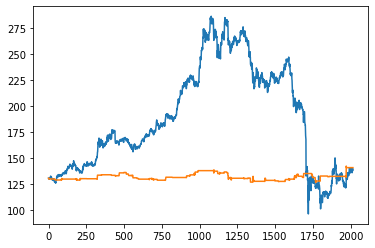

In [222]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

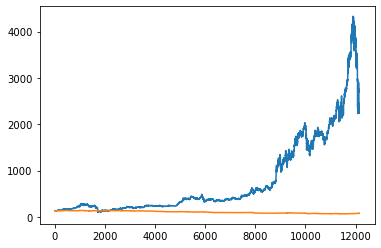

In [223]:
# PPO true - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

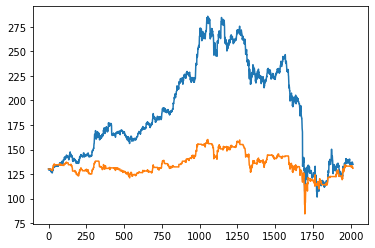

In [161]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

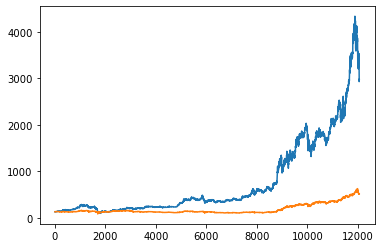

In [162]:
# PPO true - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

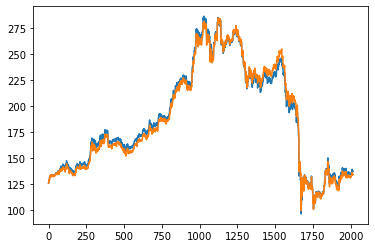

In [28]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

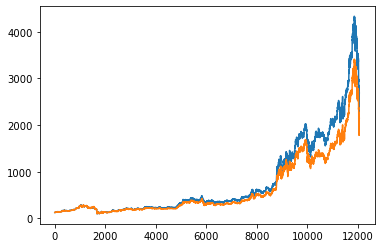

In [29]:
# PPO true - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

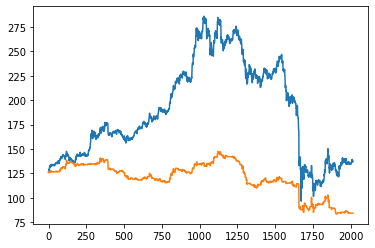

In [75]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

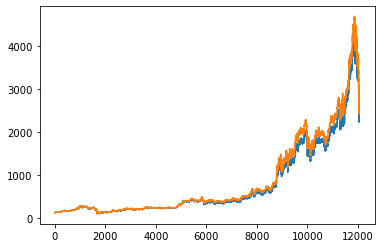

In [37]:
# PPO true - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

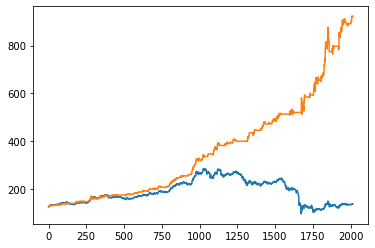

In [41]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

500K


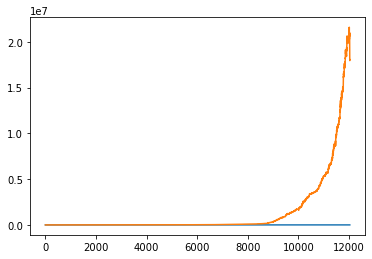

In [42]:
# PPO new
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

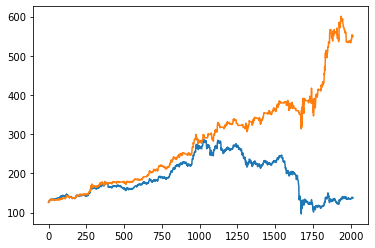

In [36]:
# PPO new
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

500K


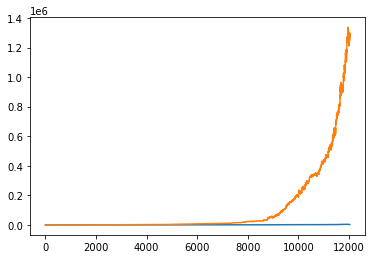

In [35]:
# PPO new
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


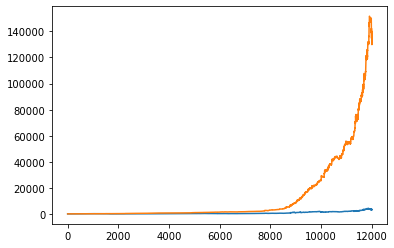

In [152]:
# PPO load
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

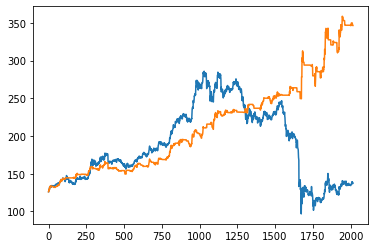

In [153]:
# PPO load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

<AxesSubplot:>

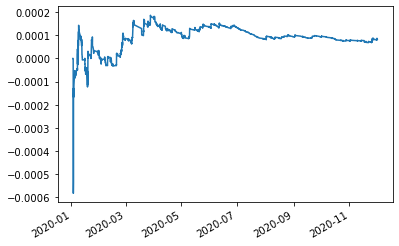

In [133]:
(pd.DataFrame(values_dict).T.value.pct_change() - klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.pct_change()).expanding().mean().plot()

<AxesSubplot:>

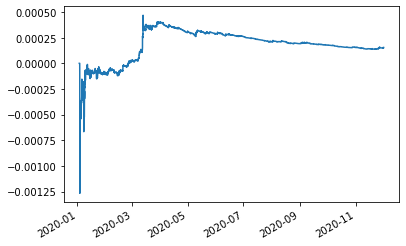

In [194]:
(pd.DataFrame(values_dict).T.value.pct_change() - klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.pct_change()).expanding().mean().plot()

<AxesSubplot:>

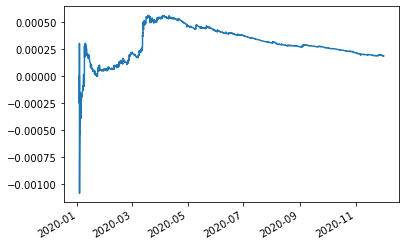

In [220]:
(pd.DataFrame(values_dict).T.value.pct_change() - klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.pct_change()).expanding().mean().plot()

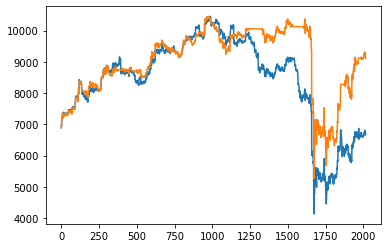

In [129]:
# DQN
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

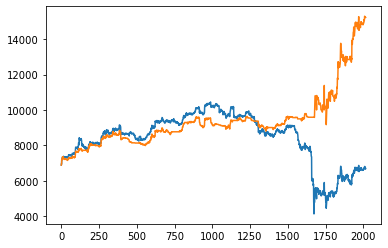

In [195]:
# PPO last
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

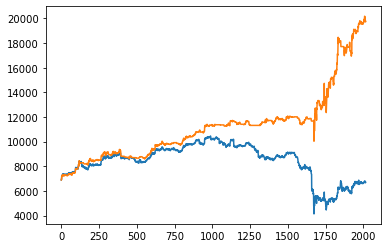

In [221]:
# PPO best
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

250K


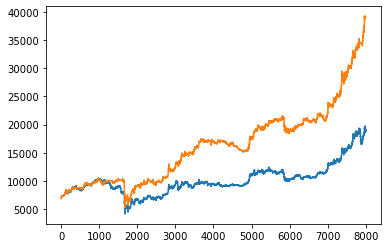

In [112]:
# DQN
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


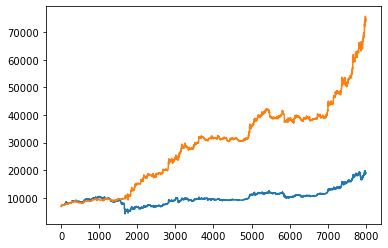

In [196]:
# PPO last
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


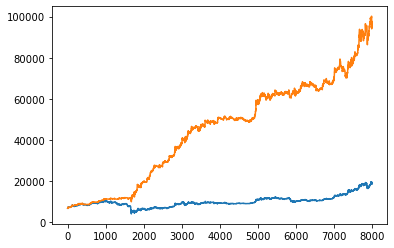

In [222]:
# PPO best
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)